<a href="https://www.kaggle.com/code/larserikrisholm/search-for-new-physics-at-the-lhc?scriptVersionId=162959922" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Search for new physics - find the Z' particle
In this exciting project, we are going to create a binary classifier that distinguishes between the Standard Model (SM) physics processes and a specific extension of the SM, which introduces a novel particle known as Z', also known as Z Prime Boson. Additionally, we will try to perform mass estimation of the Z' particle . We will be using simulated Monte Carlo (MC) data. This project aims to harness the power of Machine Learning and Deep Learning to advance the exploration of new physics. The success of this endeavor has the potential to offer physicists valuable tools for enhancing our comprehension of the universe, potentially shedding light on unresolved phenomena, such as the enigmatic existence of dark matter, which currently challenges the predictions of the Standard Model.

### Import libraries

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import joblib
import time

### Specify path to the dataset and list the background/signal files

In [5]:
# Specify the correct path to your file on Kaggle
path = '/kaggle/input/zparticlesearch/'

# Specify which file you want to work with here
file_name = '/mc_105986.ZZ.hdf5'

# Open the file as readonly'
f_data = h5py.File(path + file_name, 'r')

# List all groups
data = pd.DataFrame(f_data['mini'][:])

### List background and signal files
The Monte Carlo simulated datasets are available at Cern opendata (CMS Open Data). See the dataset details for more info.
Each dataset has a description of what the datasets simulates. This way we could easily distict between background and signal files, where signal files are the simulated data that may prove the presense of the hypothetical Z' particle.

In [6]:
# List of background files
background_files = [
    'mc_105986.ZZ.hdf5',
    'mc_105987.WZ.hdf5',
    'mc_110090.stop_tchan_top.hdf5',
    'mc_110091.stop_tchan_antitop.hdf5',
    'mc_110119.stop_schan.hdf5',
    'mc_110140.stop_wtchan.hdf5',
    'mc_117049.ttbar_had.hdf5',
    'mc_117050.ttbar_lep.hdf5',
    'mc_147770.Zee.hdf5',
    'mc_147771.Zmumu.hdf5',
    'mc_147772.Ztautau.hdf5',
    'mc_167740.WenuWithB.hdf5',
    'mc_167743.WmunuWithB.hdf5',
    'mc_167746.WtaunuWithB.hdf5',
    'mc_173041.DYeeM08to15.hdf5',
    'mc_173042.DYeeM15to40.hdf5',
    'mc_173043.DYmumuM08to15.hdf5',
    'mc_173044.DYmumuM15to40.hdf5',
    'mc_173045.DYtautauM08to15.hdf5',
    'mc_173046.DYtautauM15to40.hdf5'
]


# List of signal files
signal_files = [
    'mc_110901.ZPrime500.hdf5',
    'mc_110902.ZPrime750.hdf5',
    'mc_110903.ZPrime1000.hdf5',
    'mc_110905.ZPrime1500.hdf5',
    'mc_110906.ZPrime1750.hdf5',
    'mc_110907.ZPrime2000.hdf5',
    'mc_110909.ZPrime2500.hdf5'
]

### Inspect the Dataset

In [7]:
# Print the first few rows of the DataFrame
pd.set_option('display.max_columns', None) # Set the option to display all columns
data.head()

,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z
0,0,105986,25001,54897.203125,0.059601,0.000000,0.143288,0.882837,6843.874023,-0.298063,53914.511719,0,1,87731.015625,0.116885,0.0,-1.108722,0.511836,5493.526855,0.059560,52111.167969,0,1,65074.261719,0.058257,0.0,-0.791613,0.858343,6688.428223,-0.328393,48667.664062,0,1,40973.019531,0.058846,0.0,0.002223,0.862189,6724.734375,2.909748,40417.300781,0,1,135741.25,0.059625,0.0,-2.223047,0.736373,4504.304199,2.825874,29039.128906,0,1,37984.300781,0.052396,0.0,-0.806043,0.0,7321.072266,-0.962507,27756.451172,0,0,41844.773438,0.052396,0.0,0.896861,0.0,3981.717529,1.347423,29131.917969,0,0,77520.414062,0.308235,0.0,1.645905,0.30565,6695.60498,-2.637031,28718.089844,0,1,108869.257812,0.059399,0.0,-2.052256,0.408364,5281.11084,1.49879,27481.082031,0,1,0,35308.468750,-1.0,-0.261758,54.295437,1309114624,0.659947,34132.289062,0.000000,0.006909,0.017931,1095761920,-0.093284,30114.939453,1.0,-0.697808,616.163330,1269833728,-0.485311,24024.353516,0.0,0.011484,0.015375,1095761920,0.014866,16151.847656,1.0,1.773693,2708.451172,1300923136,0.961914,5328.63916,0.0,-0.039421,0.057254,1093664768,-0.045924,9379.862305,1.0,0.904248,6796.676758,1233185784,1.351579,6525.303711,7273.309082,0.068563,0.030913,1093664768,0.123387,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1,1.0,13005.886719,2.876399,6,195847,1.000000,1.000000,1.0,1.001046,2.186532,0.958796,0.095748,-166.555191
1,1,105986,25003,171373.312500,0.056311,0.000000,-2.006945,0.582158,8385.192383,0.490301,45193.195312,0,1,87731.015625,0.116885,0.0,-1.108722,0.511836,5493.526855,0.059560,52111.167969,0,1,65074.261719,0.058257,0.0,-0.791613,0.858343,6688.428223,-0.328393,48667.664062,0,1,40973.019531,0.058846,0.0,0.002223,0.862189,6724.734375,2.909748,40417.300781,0,1,135741.25,0.059625,0.0,-2.223047,0.736373,4504.304199,2.825874,29039.128906,0,1,37984.300781,0.052396,0.0,-0.806043,0.0,7321.072266,-0.962507,27756.451172,0,0,41844.773438,0.052396,0.0,0.896861,0.0,3981.717529,1.347423,29131.917969,0,0,77520.4

In [8]:
# Check the DataFrame's structure (size, column data types and memory usage)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Columns: 169 entries, alljet_n to vxp_z
dtypes: float32(133), int32(36)
memory usage: 80.6 MB


In [9]:
# Check for missing values
pd.set_option('display.max_rows', None) # Print all rows
data.isnull().sum()

alljet_n                      0
channelNumber                 0
eventNumber                   0
jet_1_E                       0
jet_1_MV1                     0
jet_1_SV0                     0
jet_1_eta                     0
jet_1_jvf                     0
jet_1_m                       0
jet_1_phi                     0
jet_1_pt                      0
jet_1_trueflav                0
jet_1_truthMatched            0
jet_2_E                       0
jet_2_MV1                     0
jet_2_SV0                     0
jet_2_eta                     0
jet_2_jvf                     0
jet_2_m                       0
jet_2_phi                     0
jet_2_pt                      0
jet_2_trueflav                0
jet_2_truthMatched            0
jet_3_E                       0
jet_3_MV1                     0
jet_3_SV0                     0
jet_3_eta                     0
jet_3_jvf                     0
jet_3_m                       0
jet_3_phi                     0
jet_3_pt                      0
jet_3_tr

### Plot All the Features

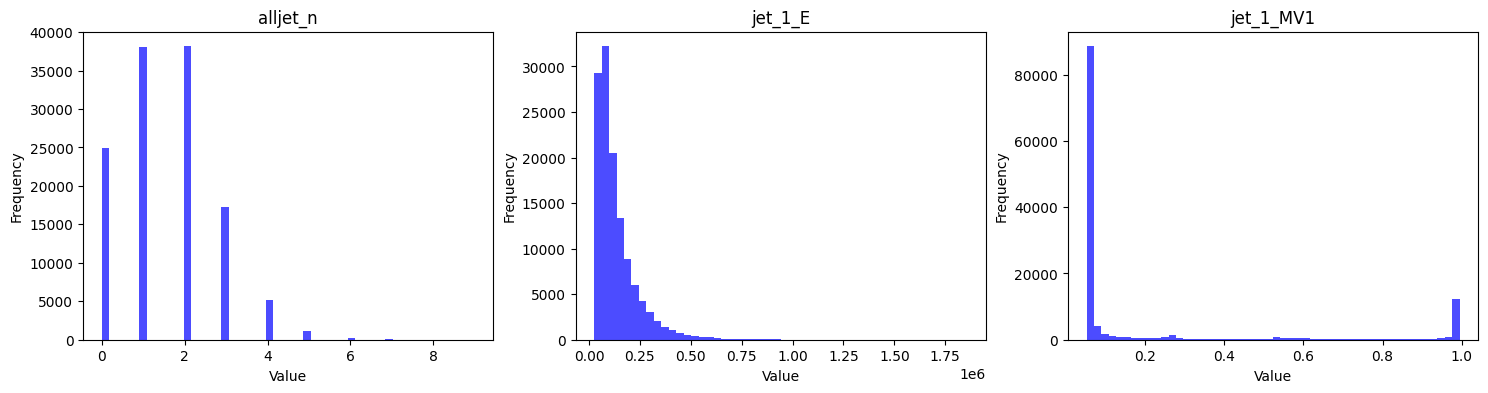

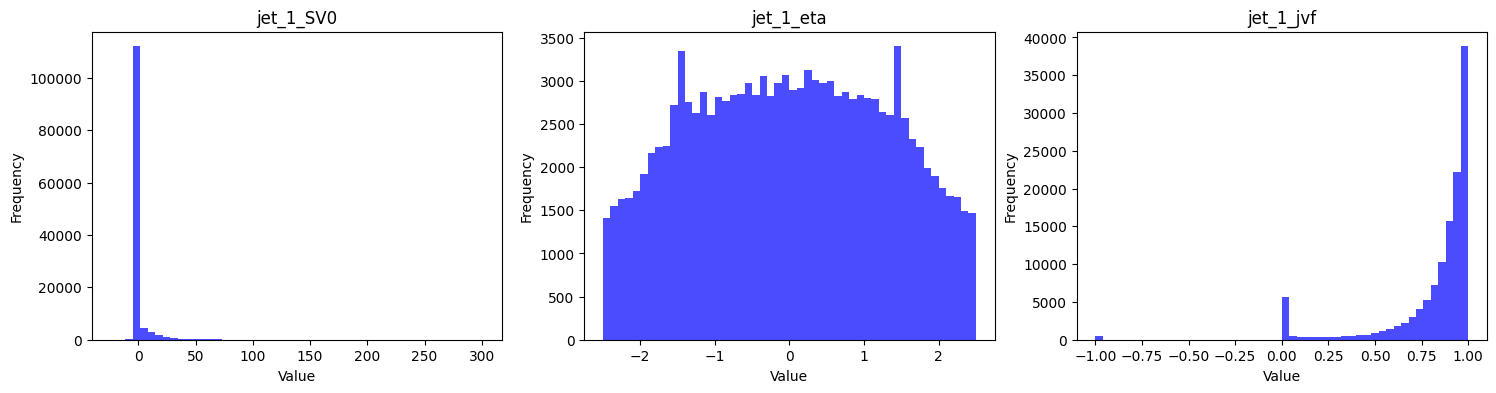

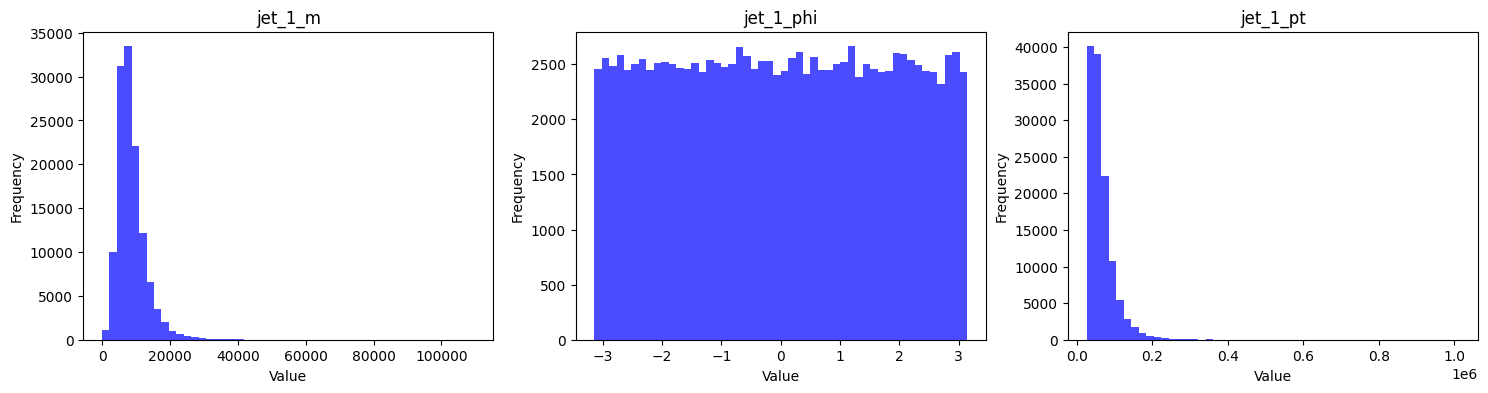

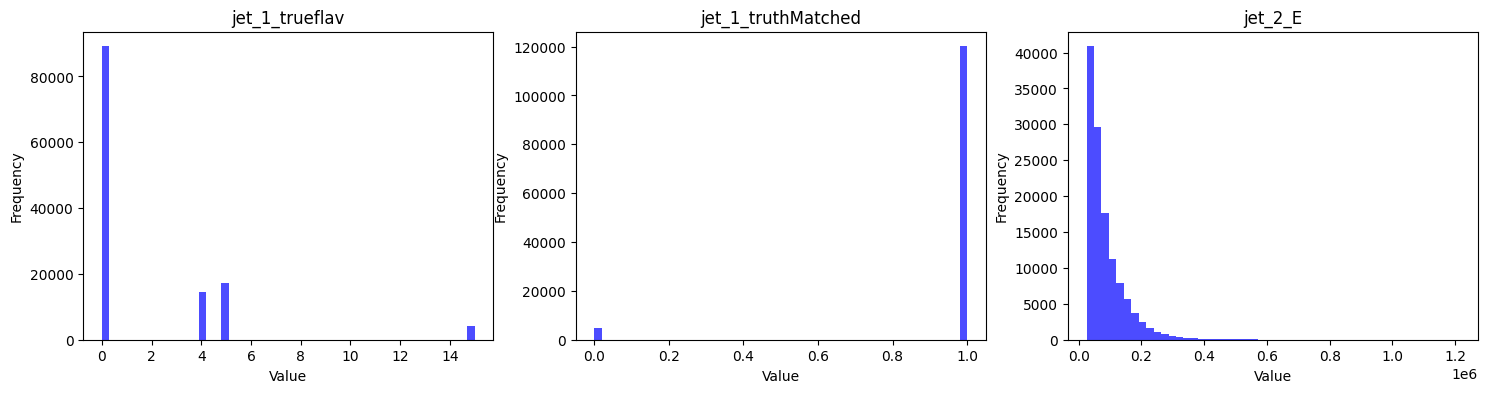

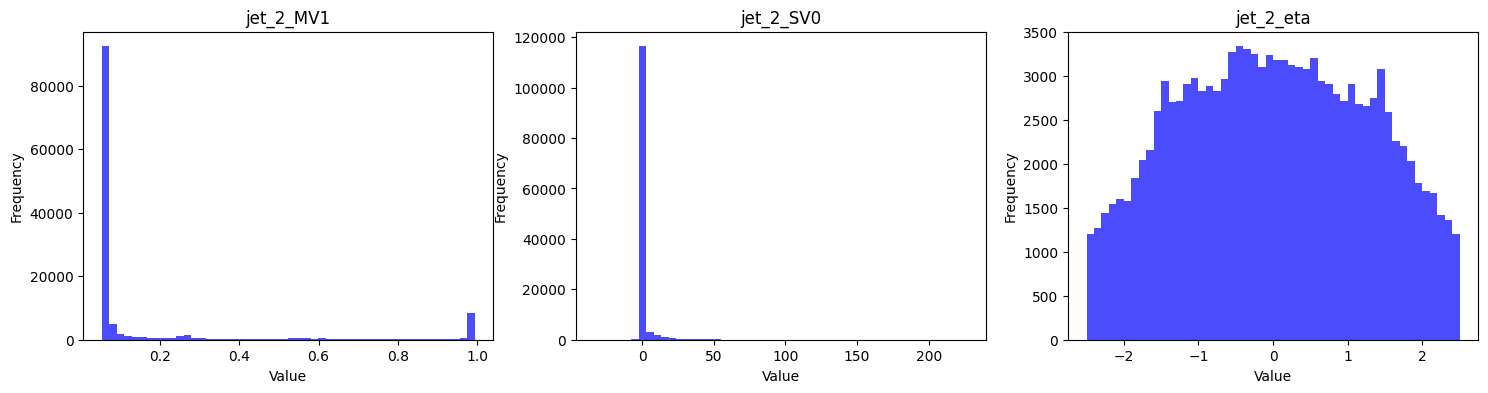

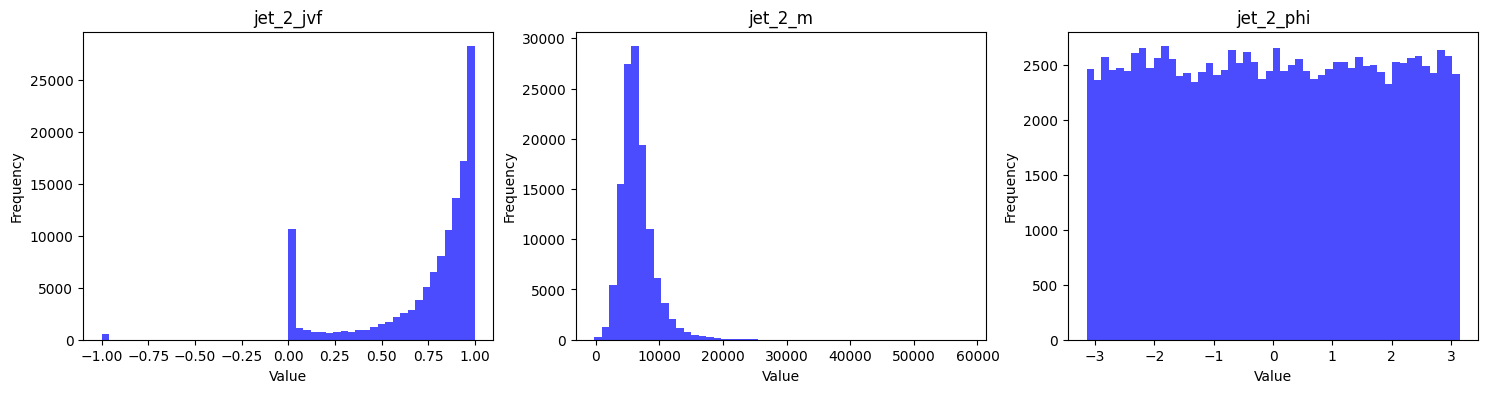

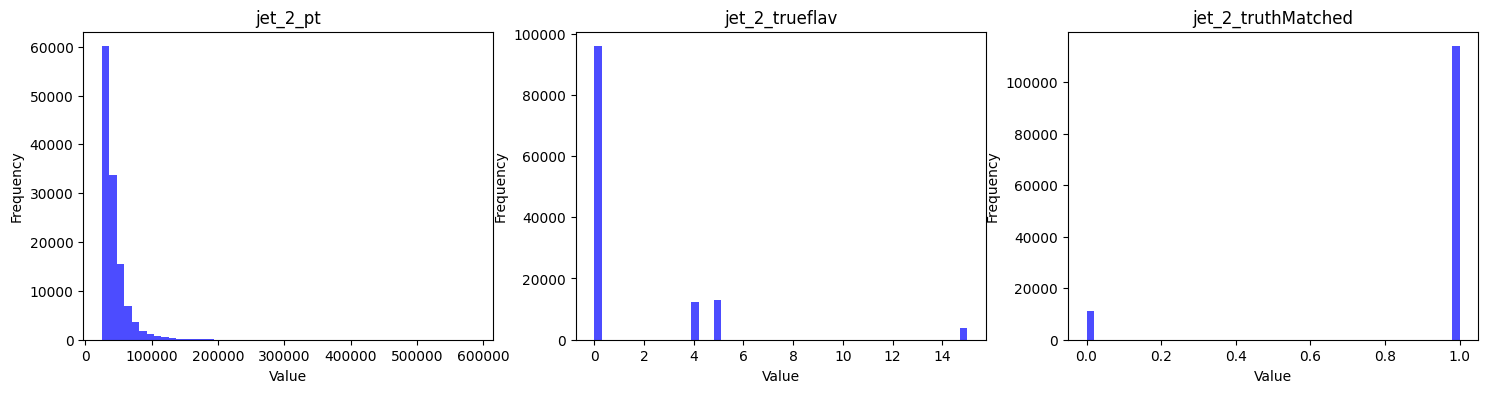

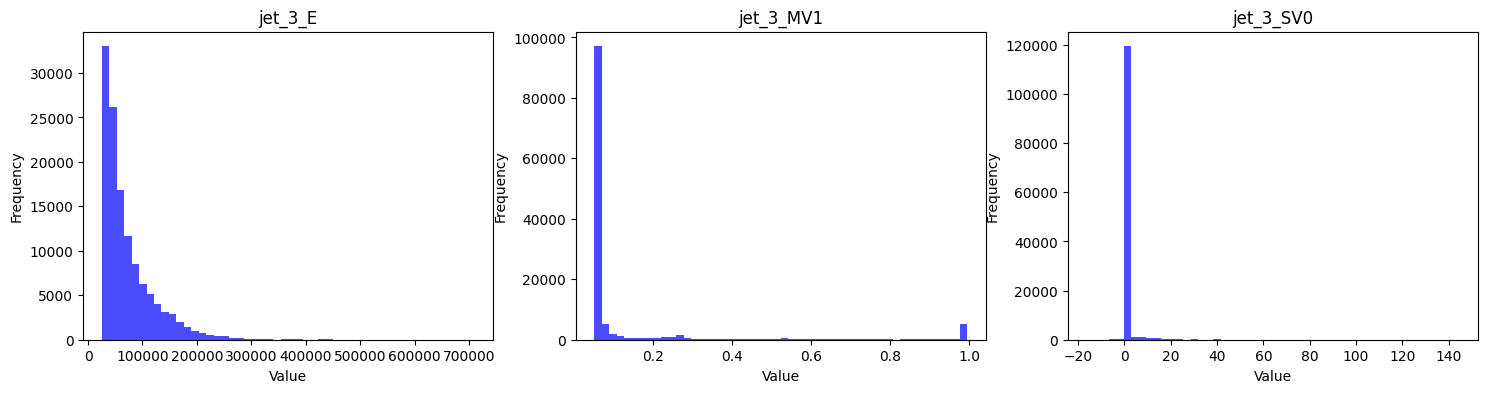

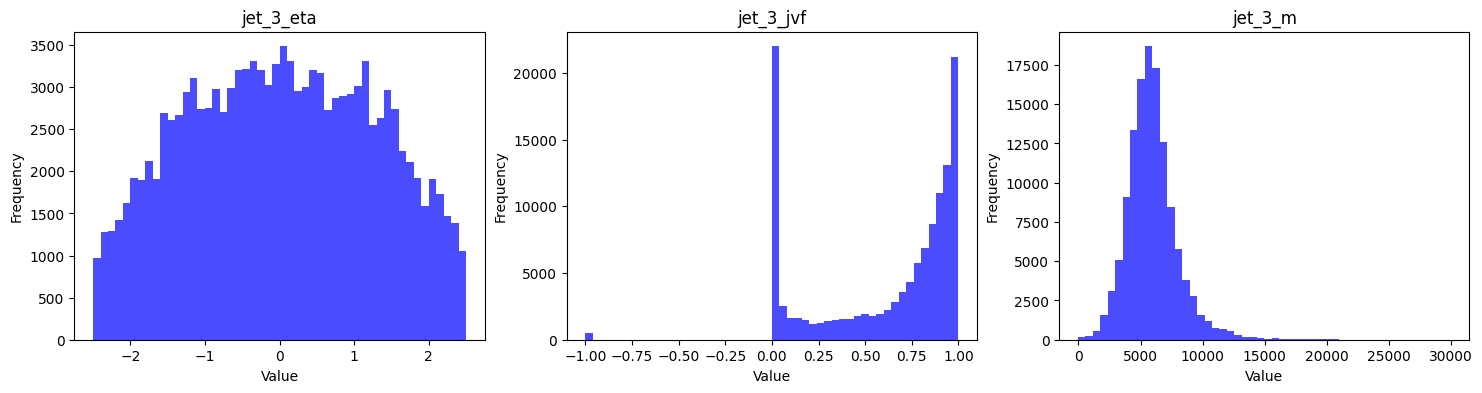

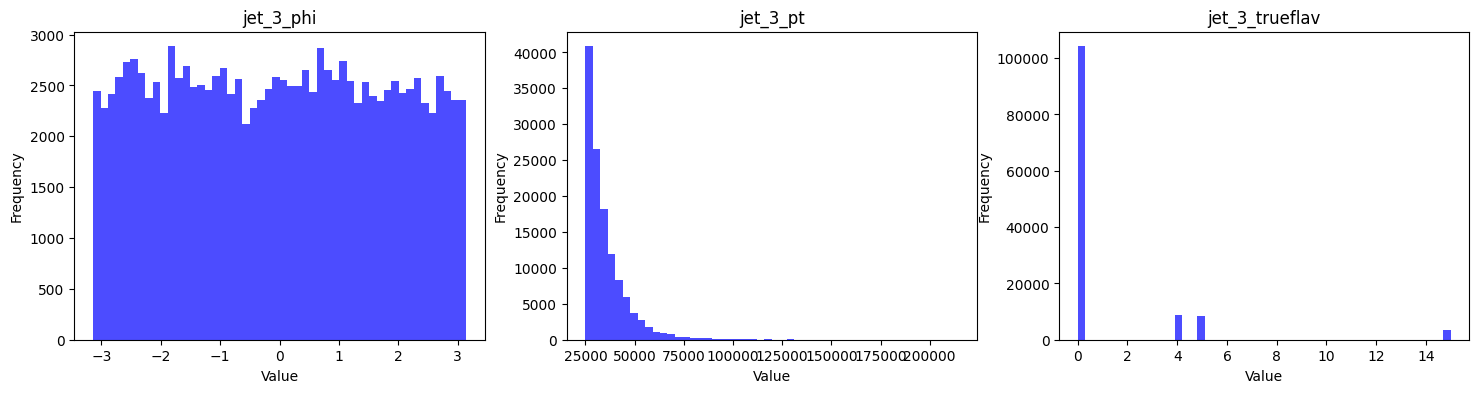

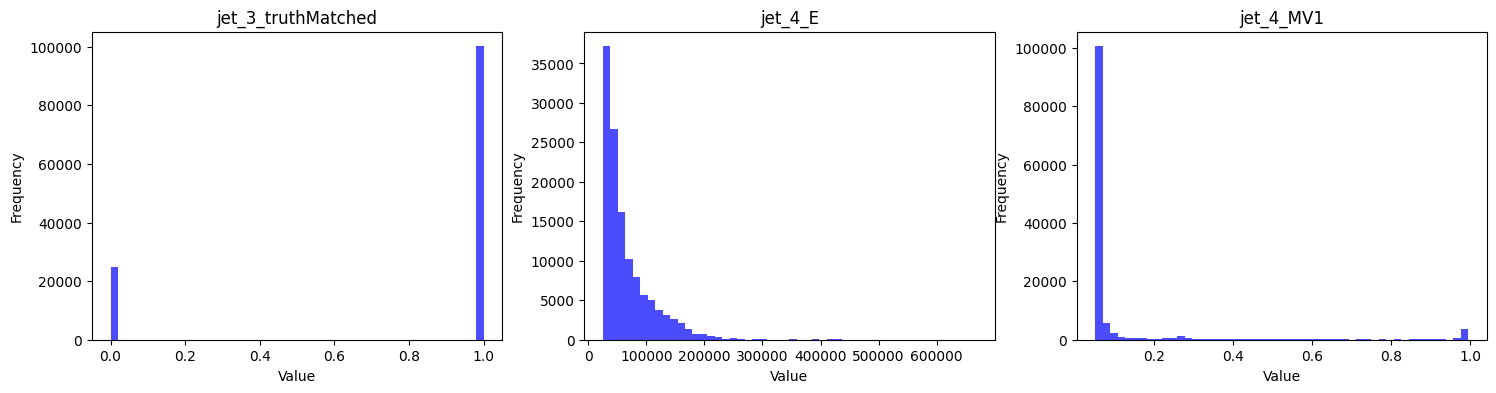

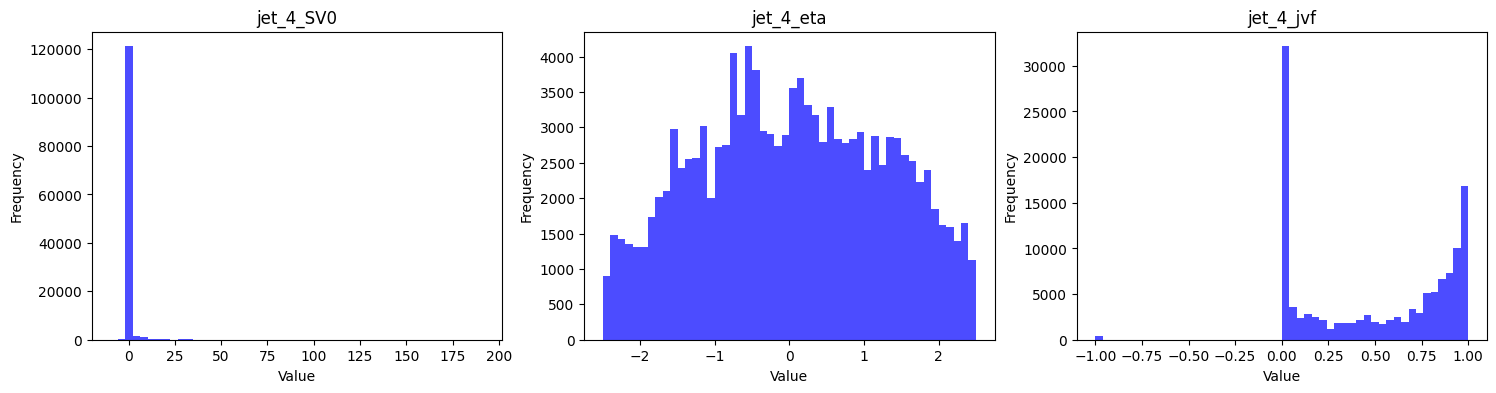

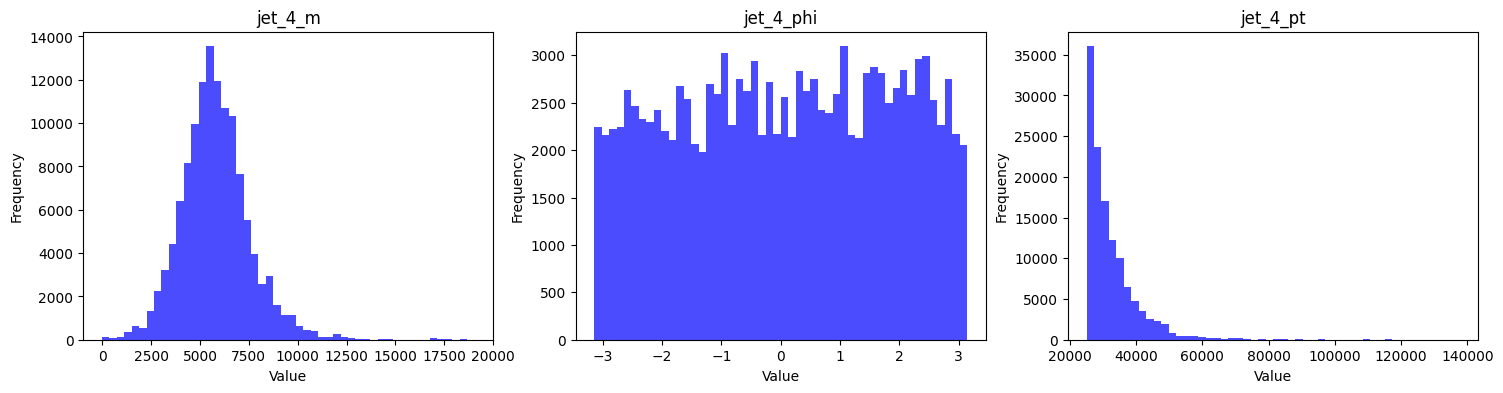

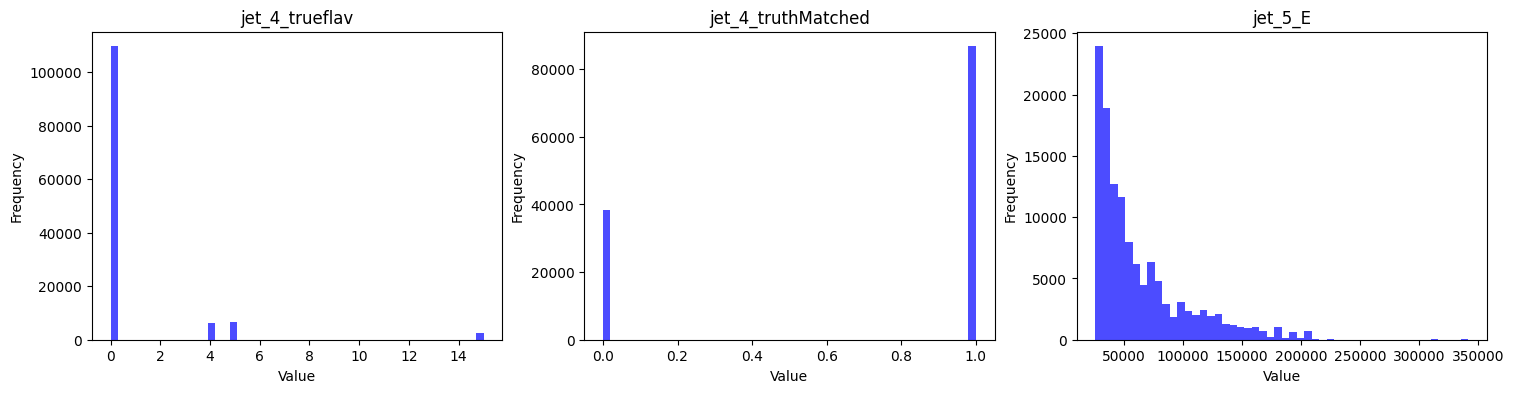

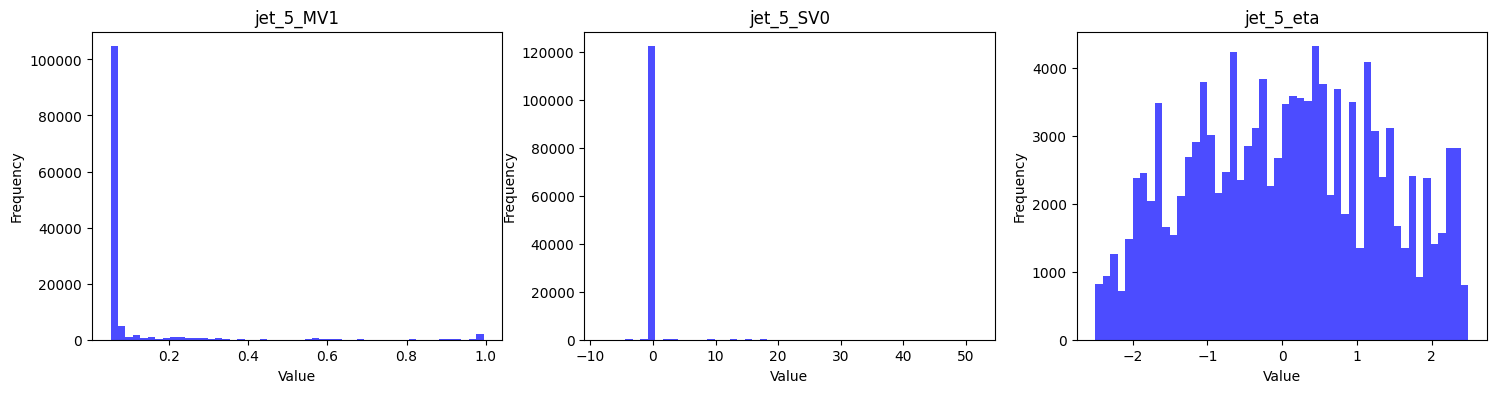

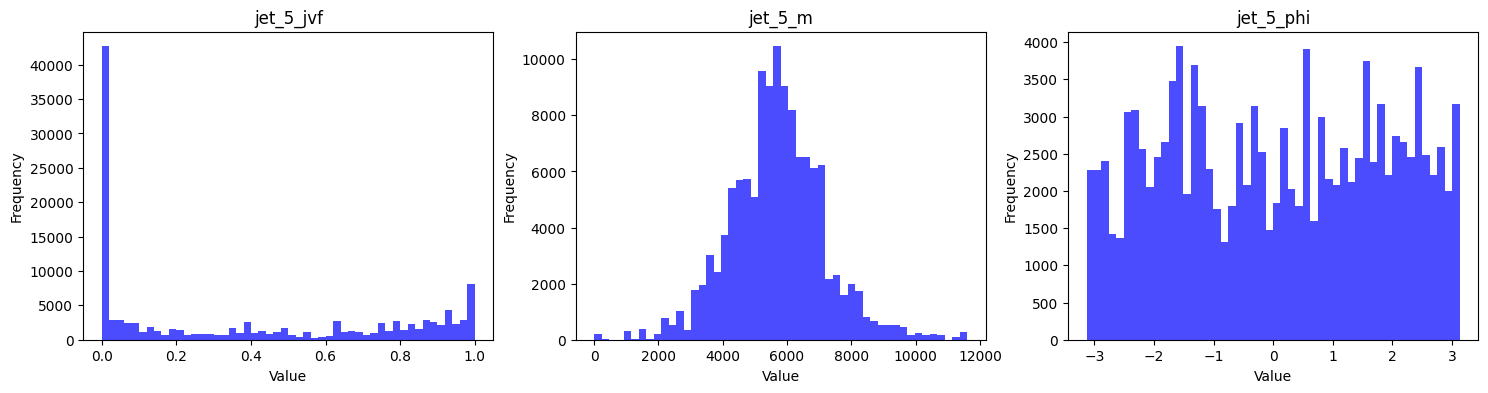

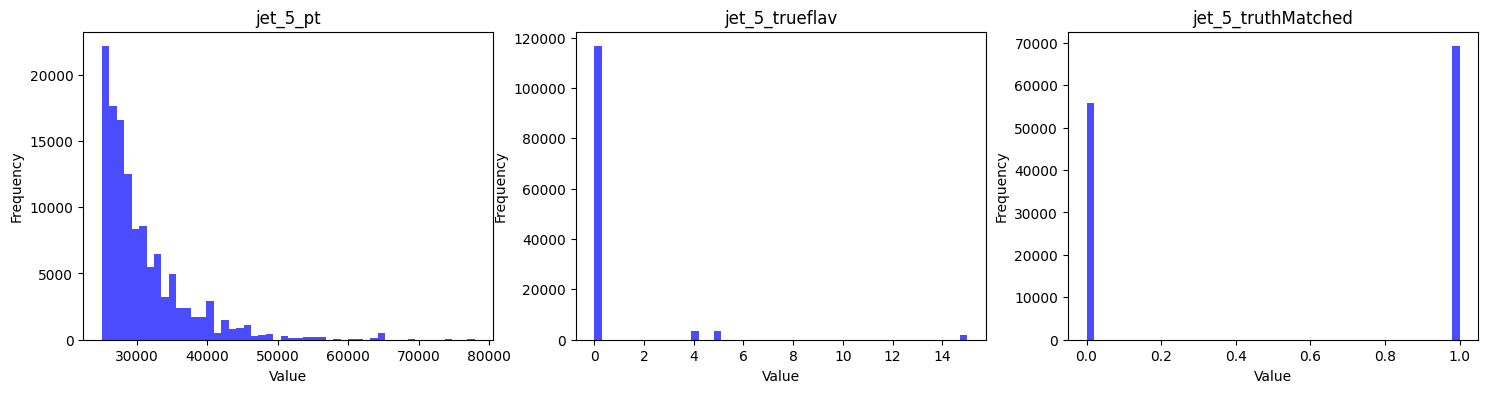

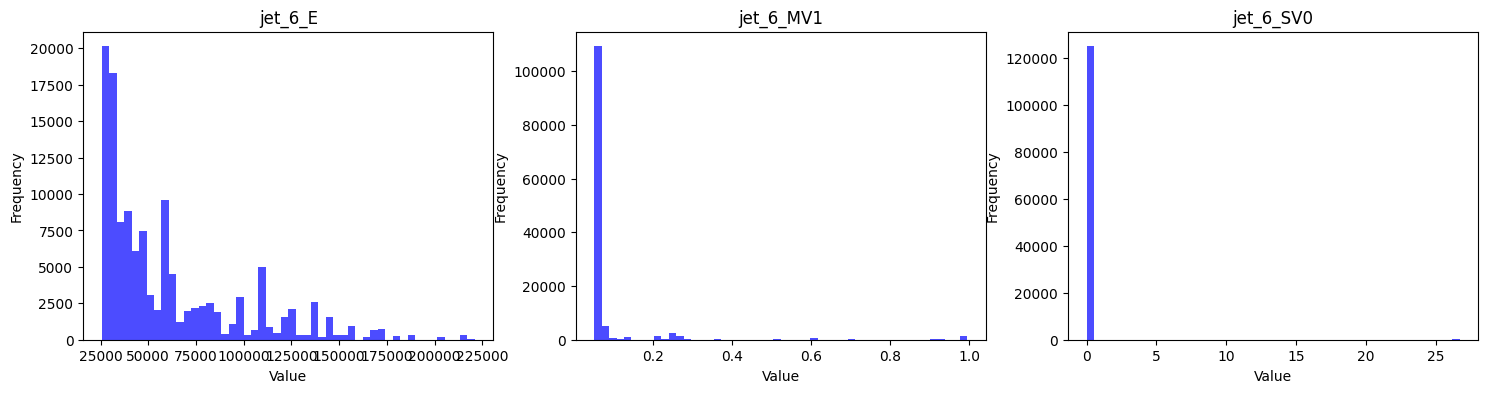

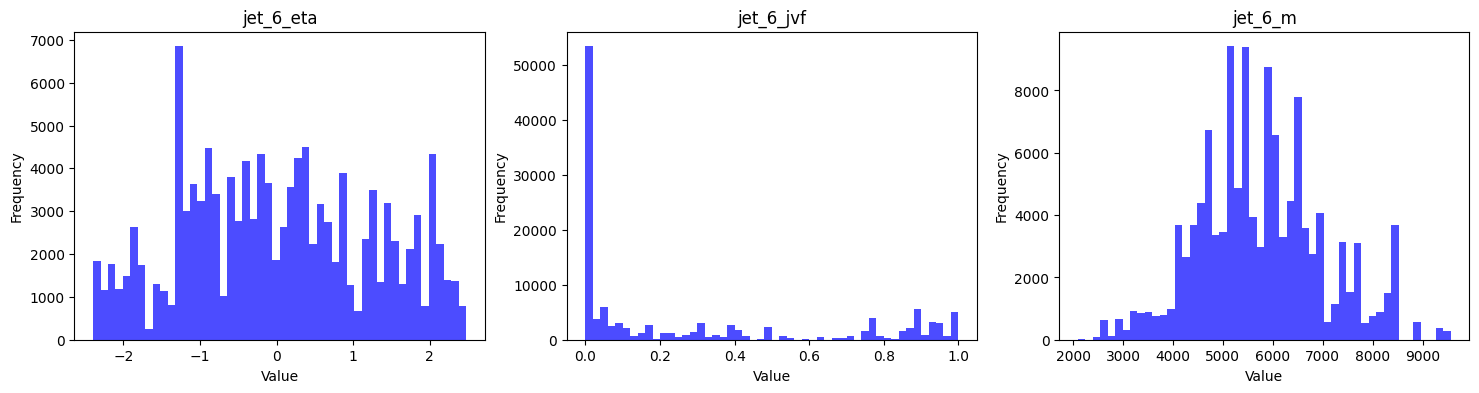

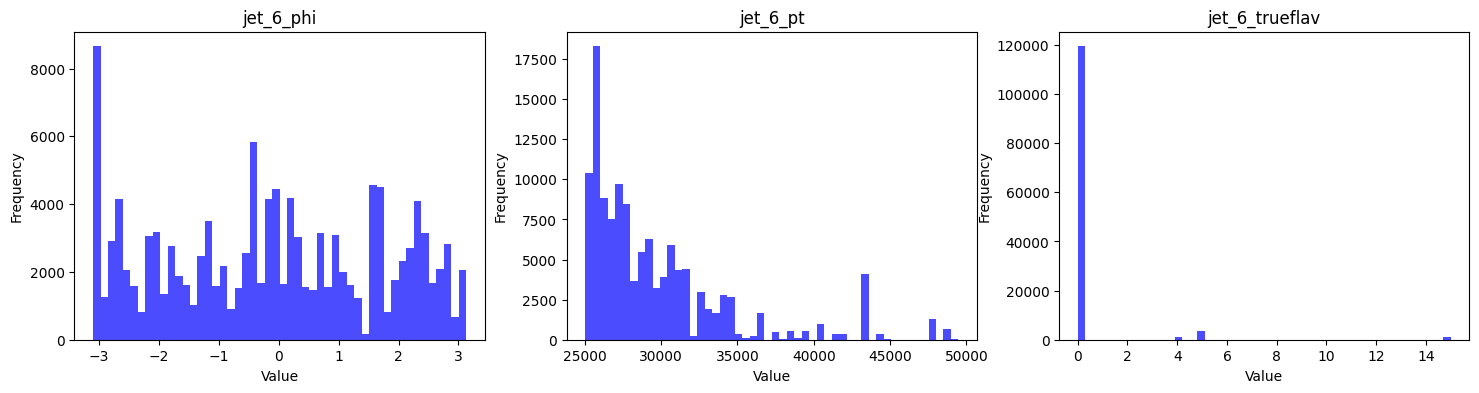

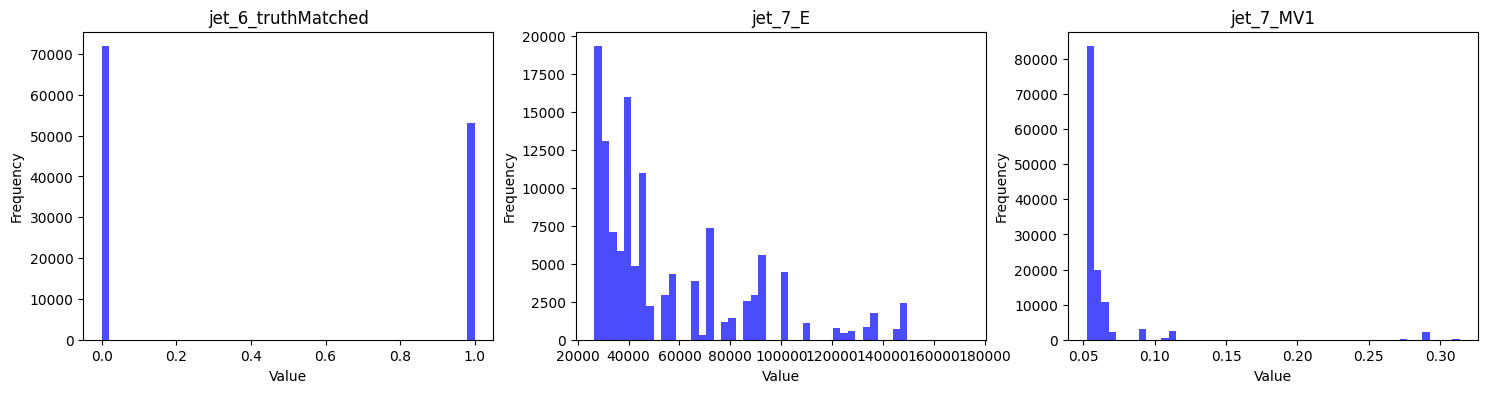

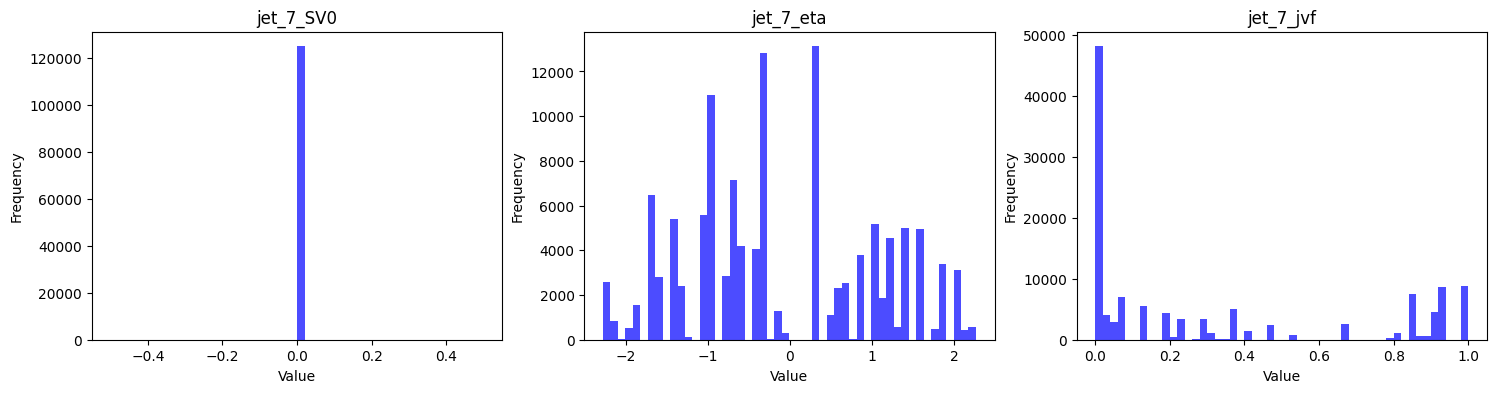

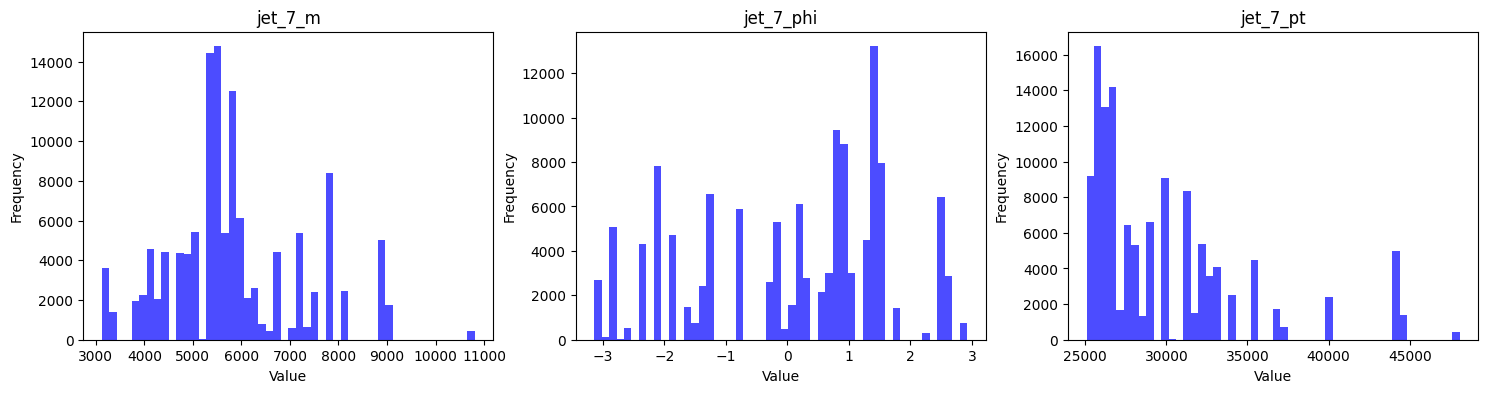

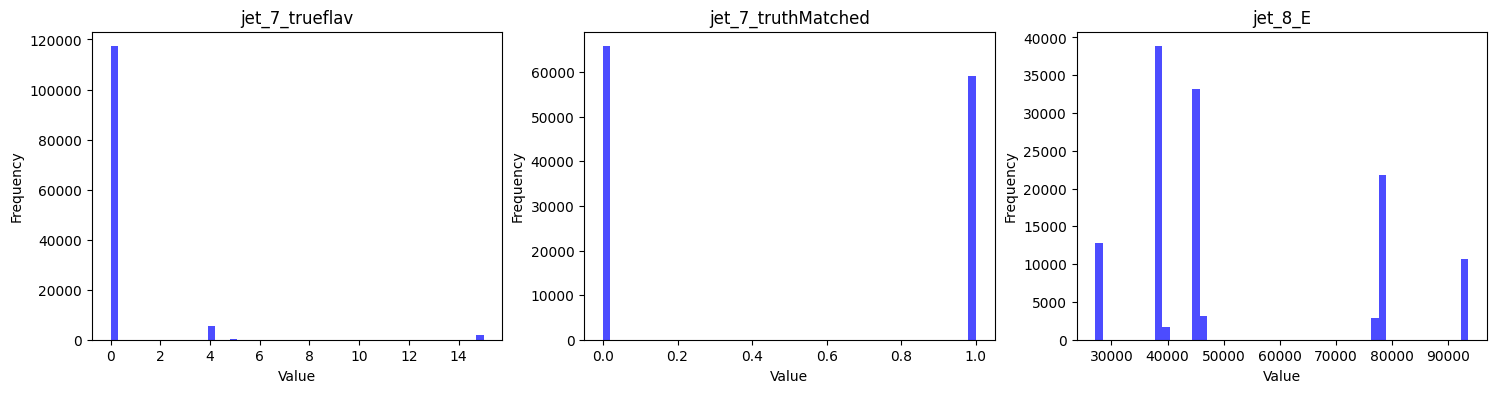

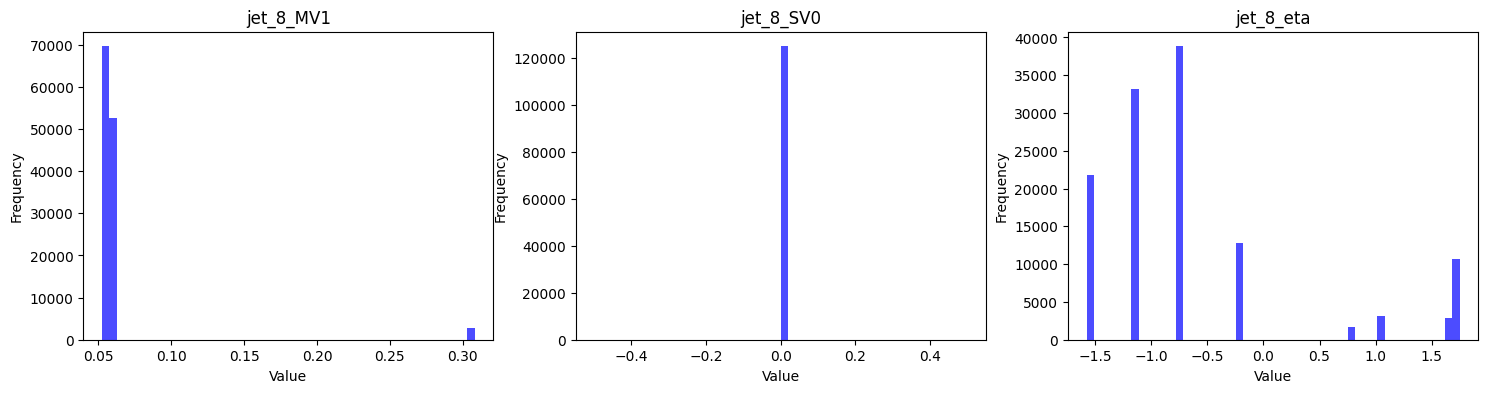

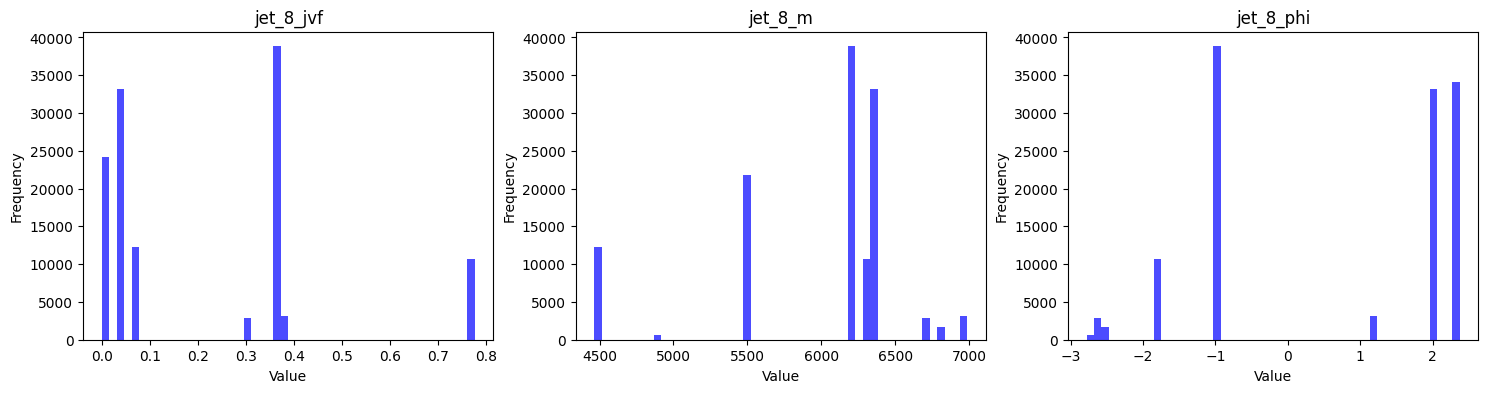

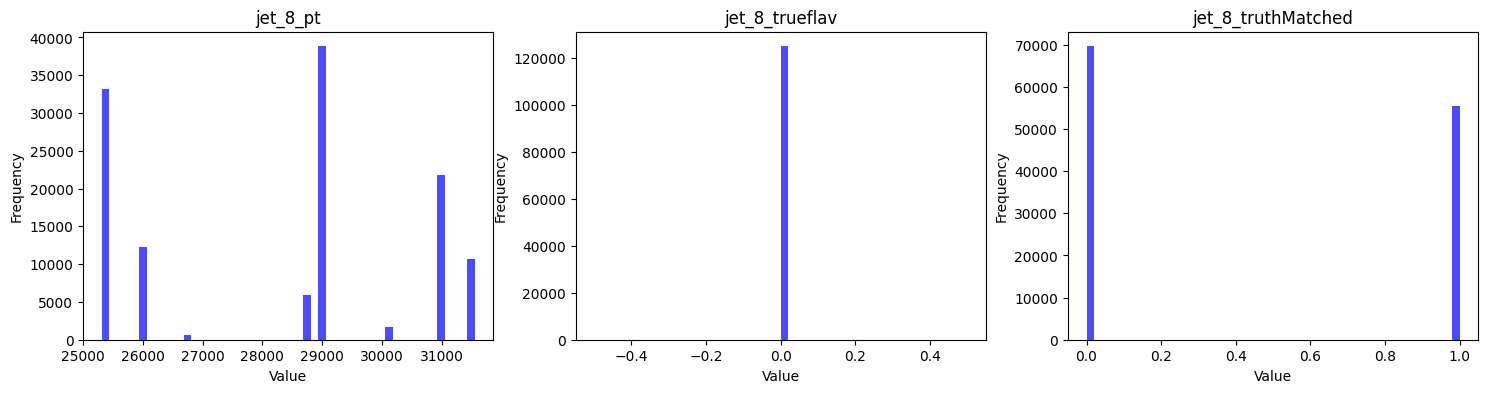

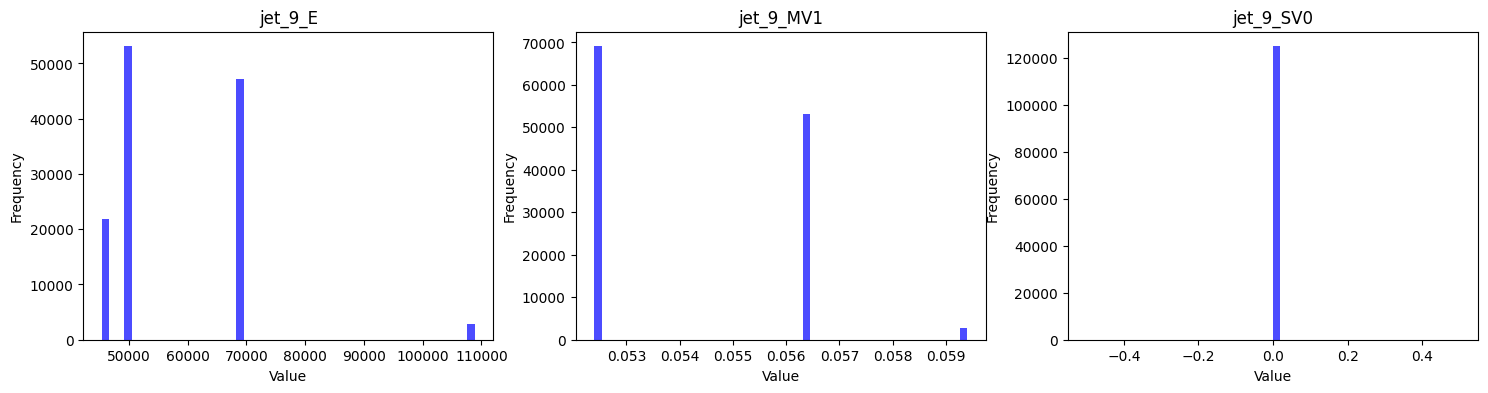

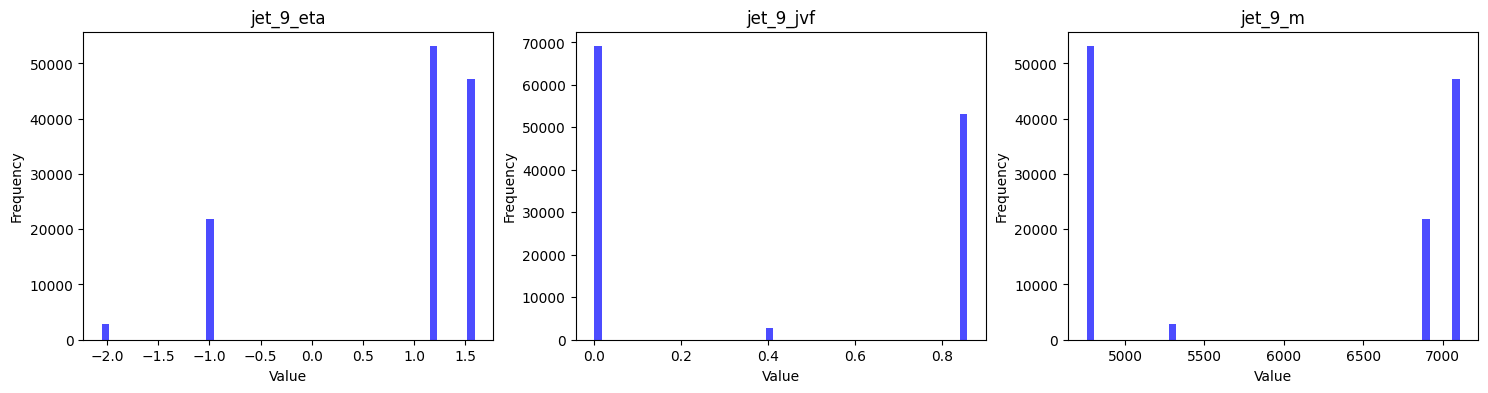

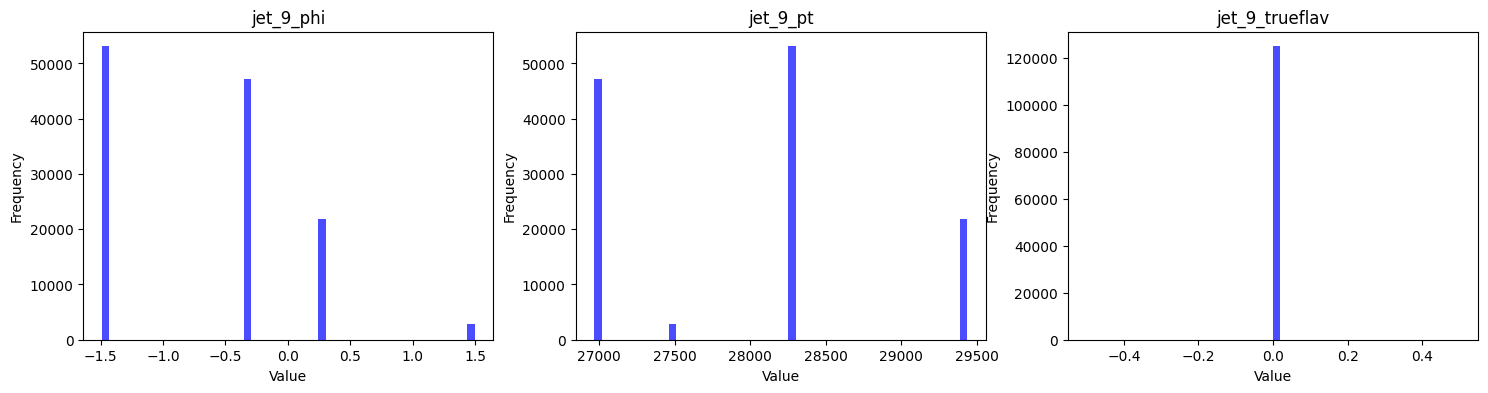

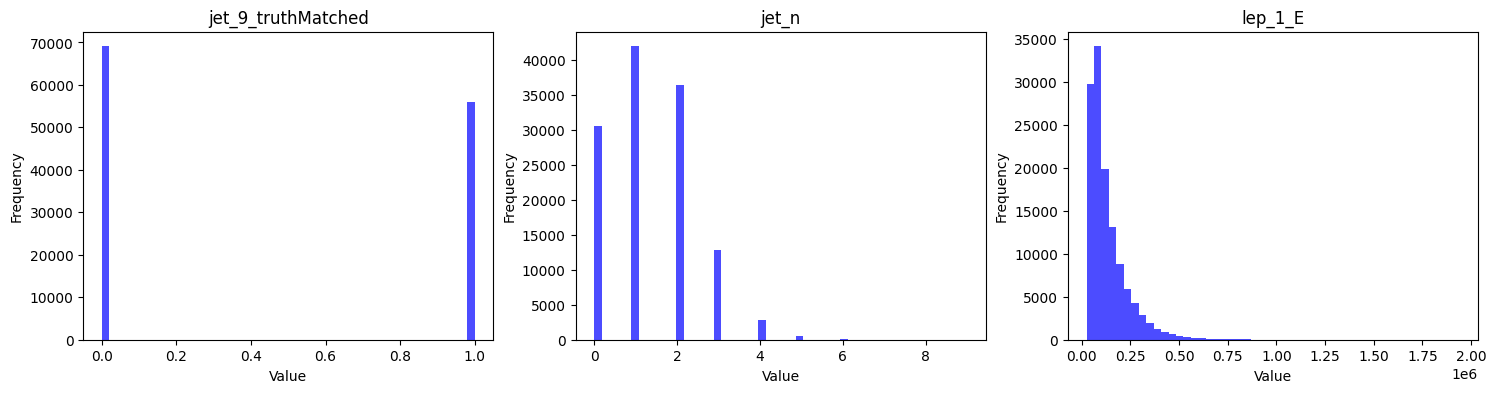

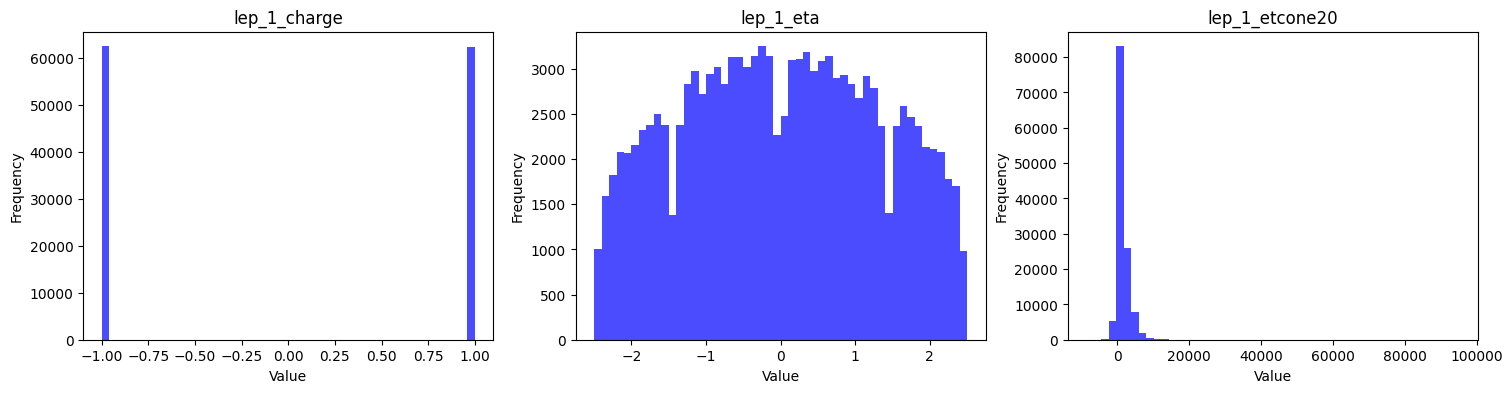

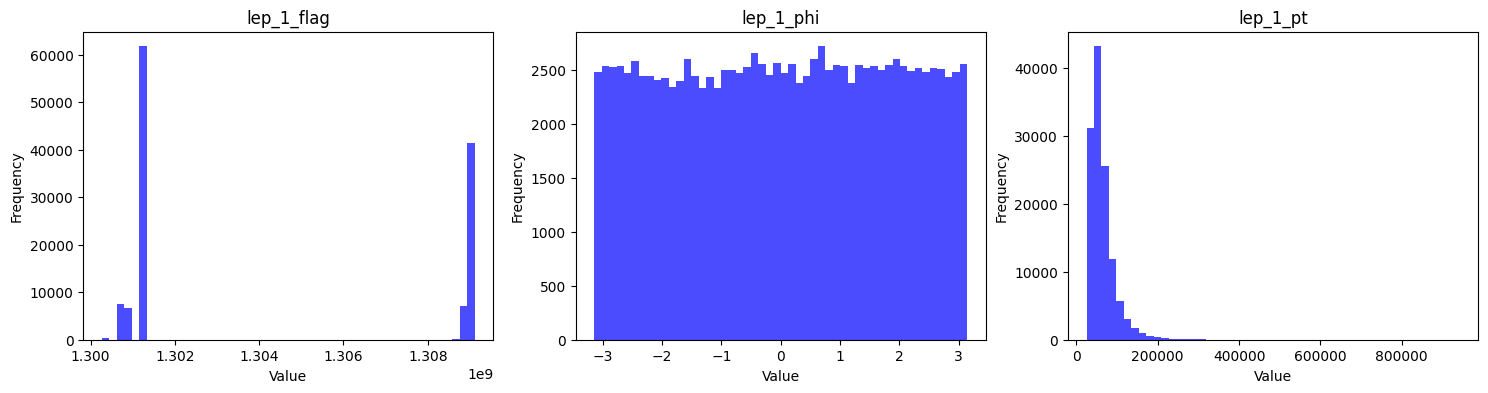

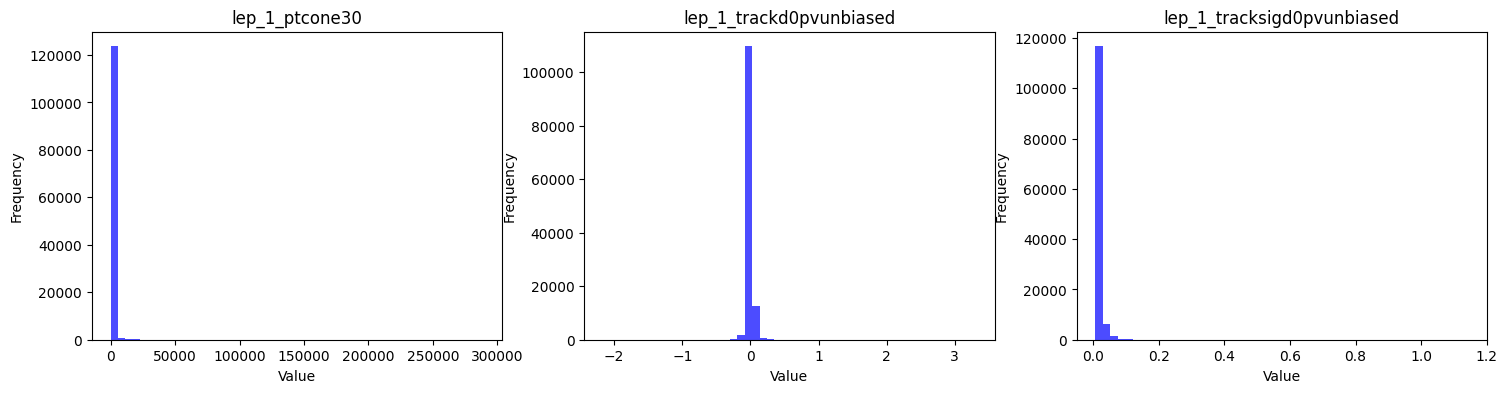

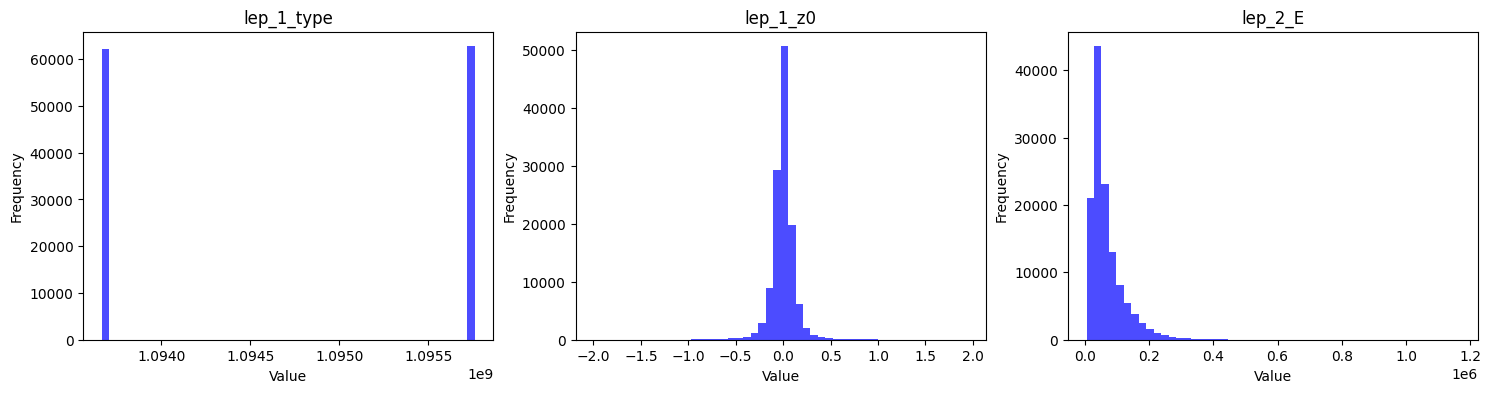

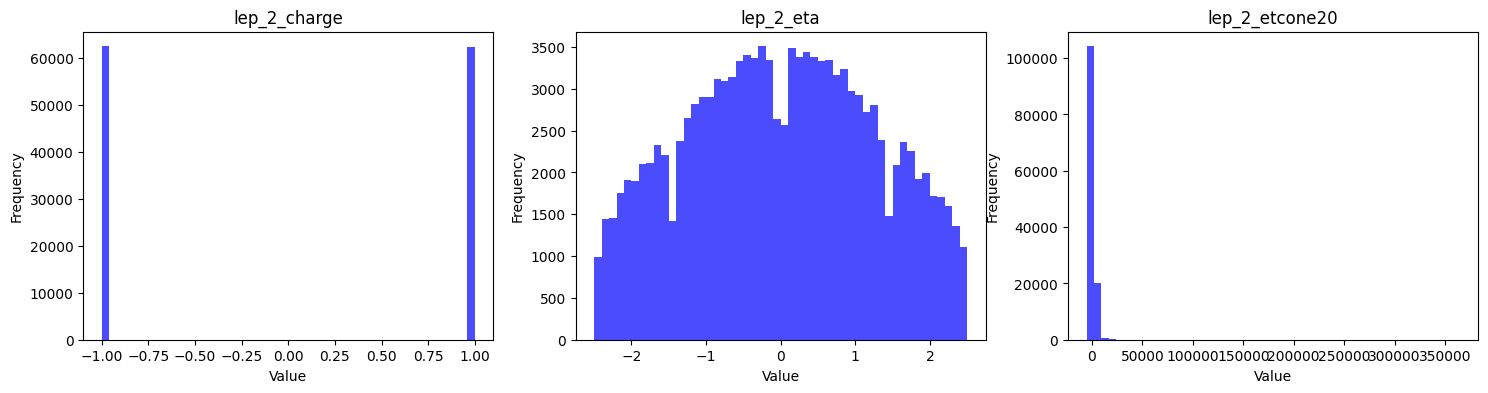

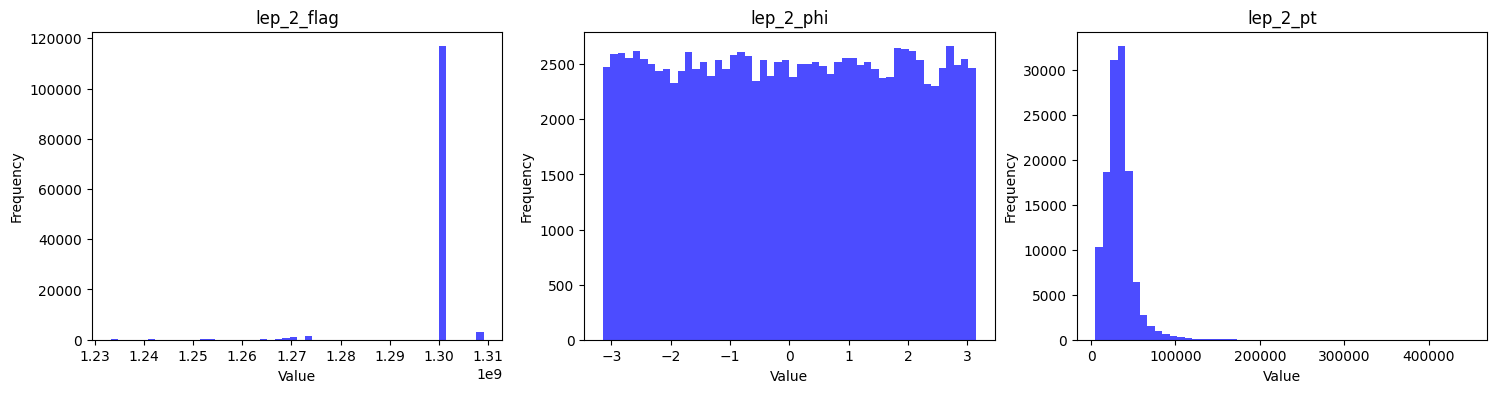

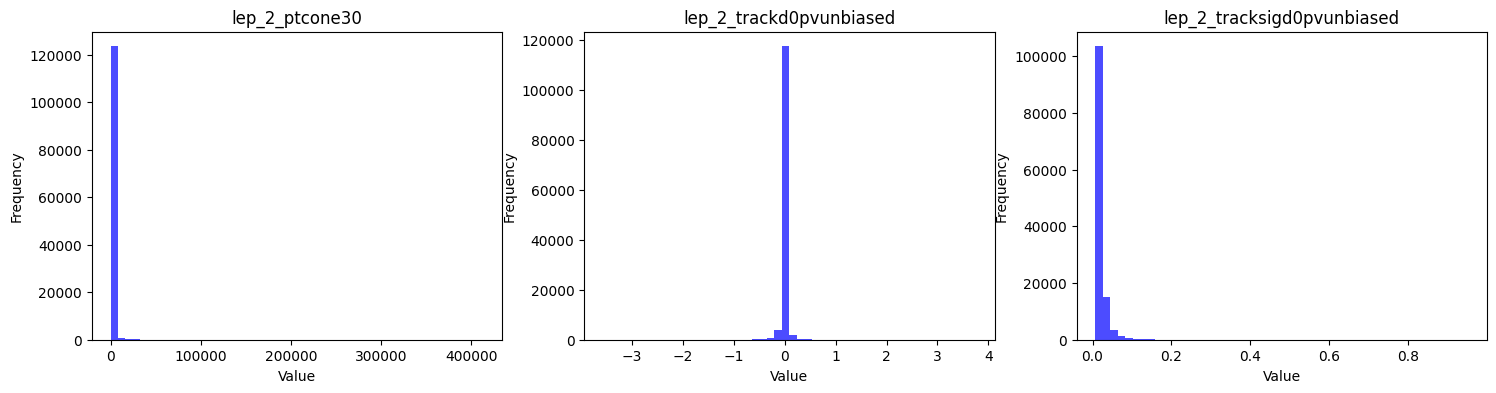

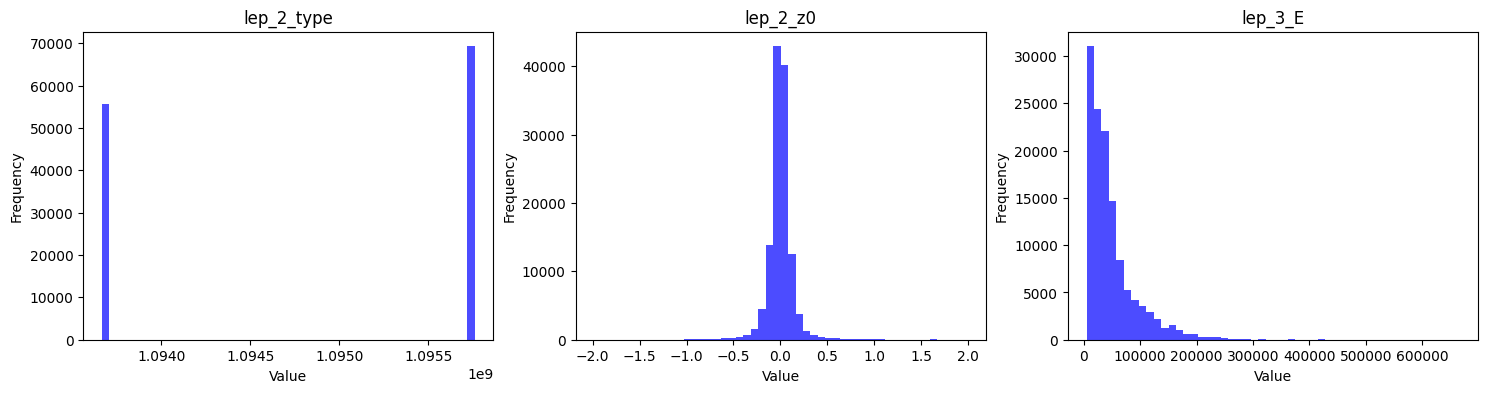

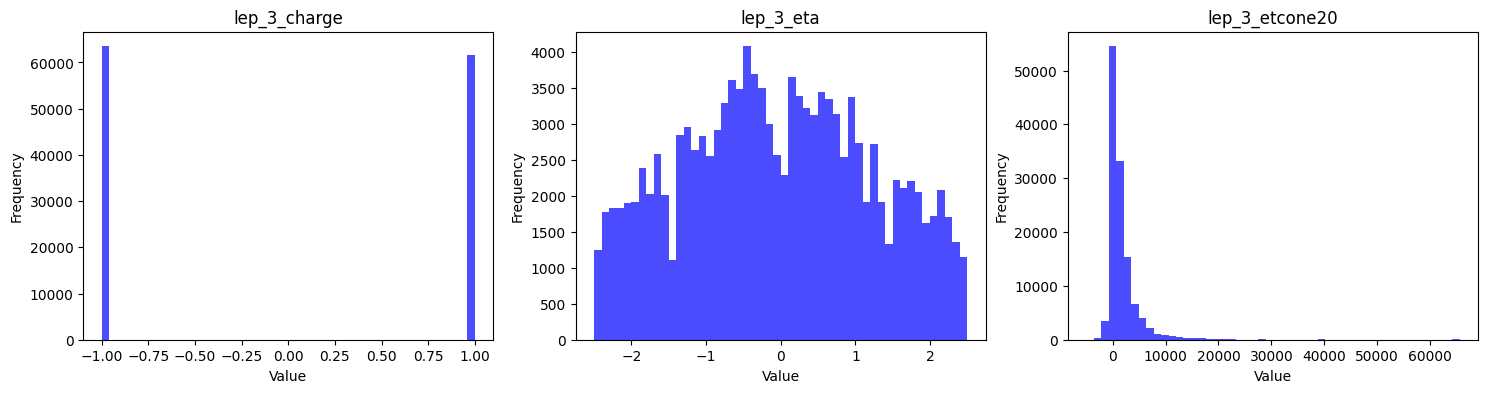

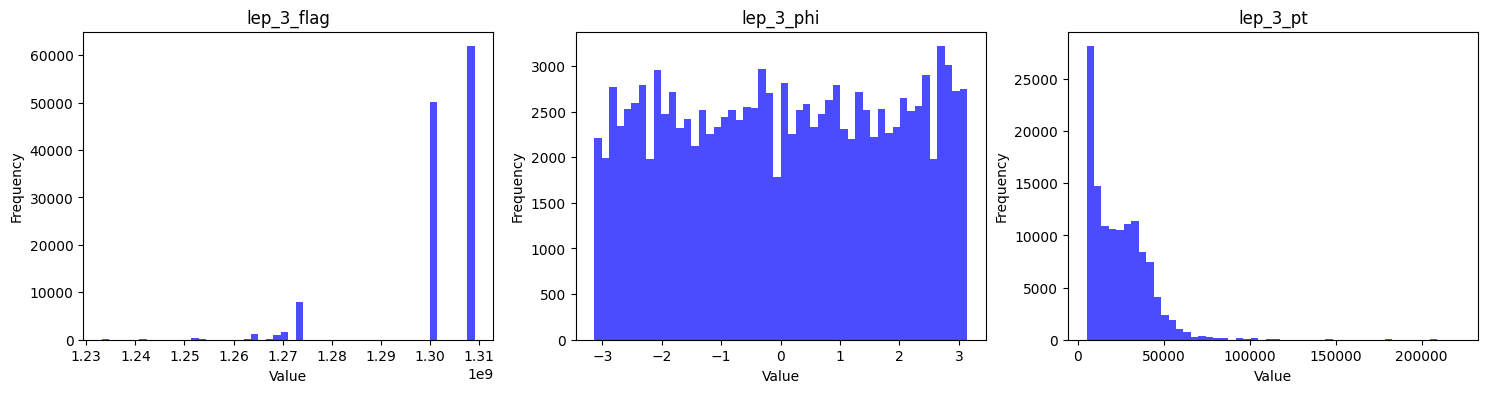

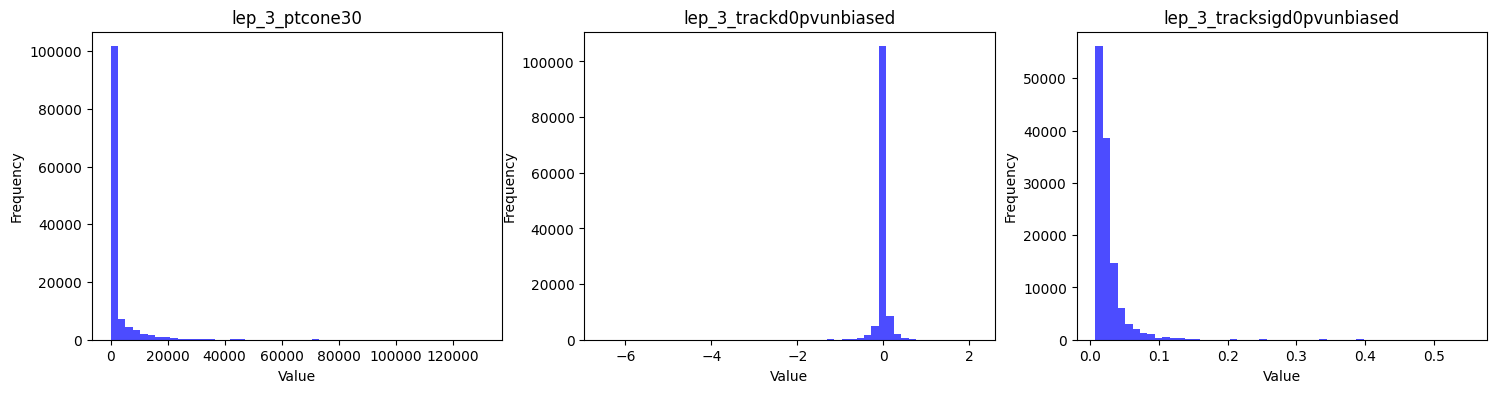

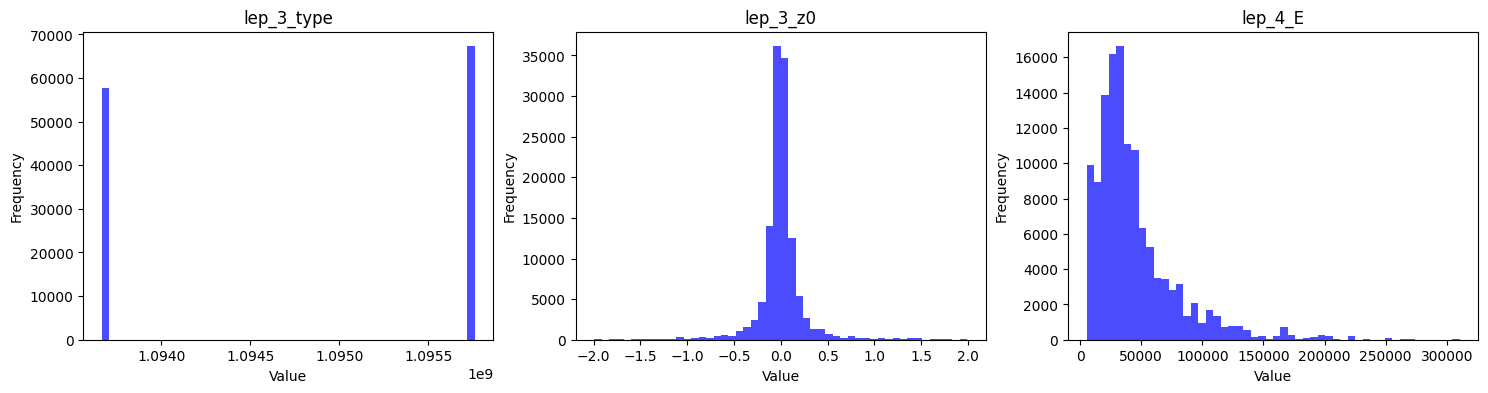

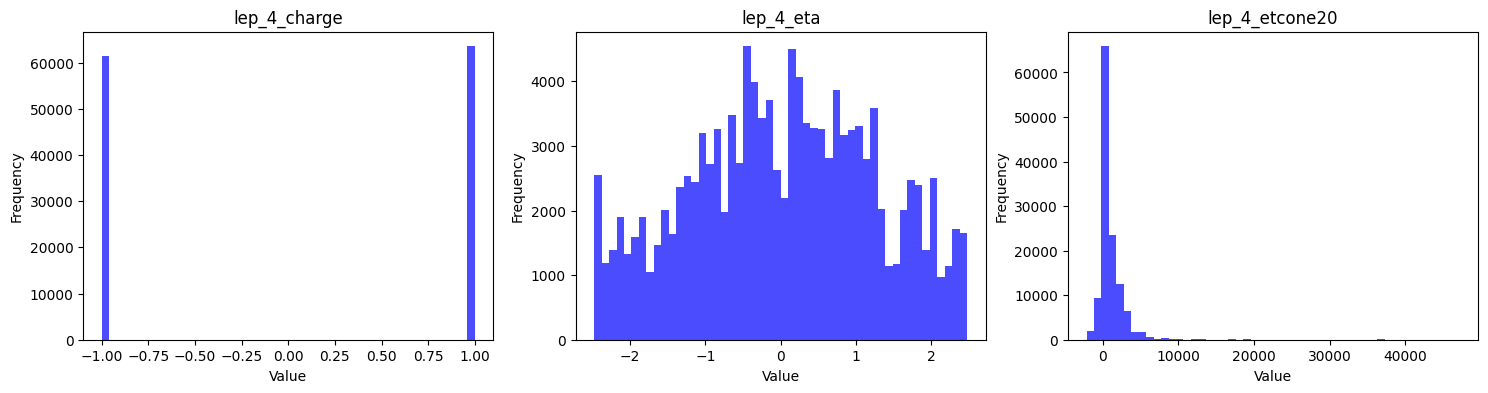

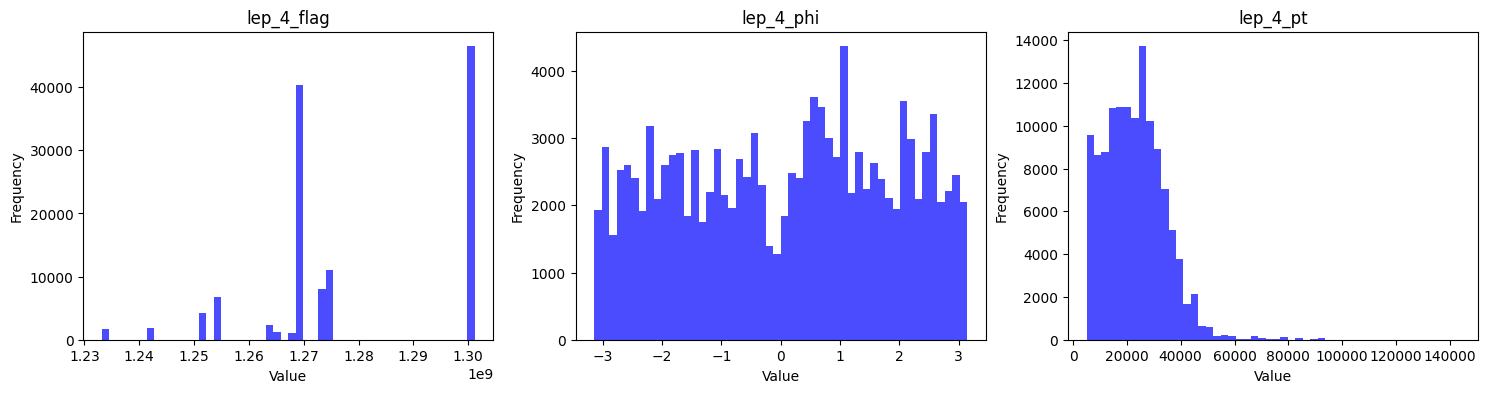

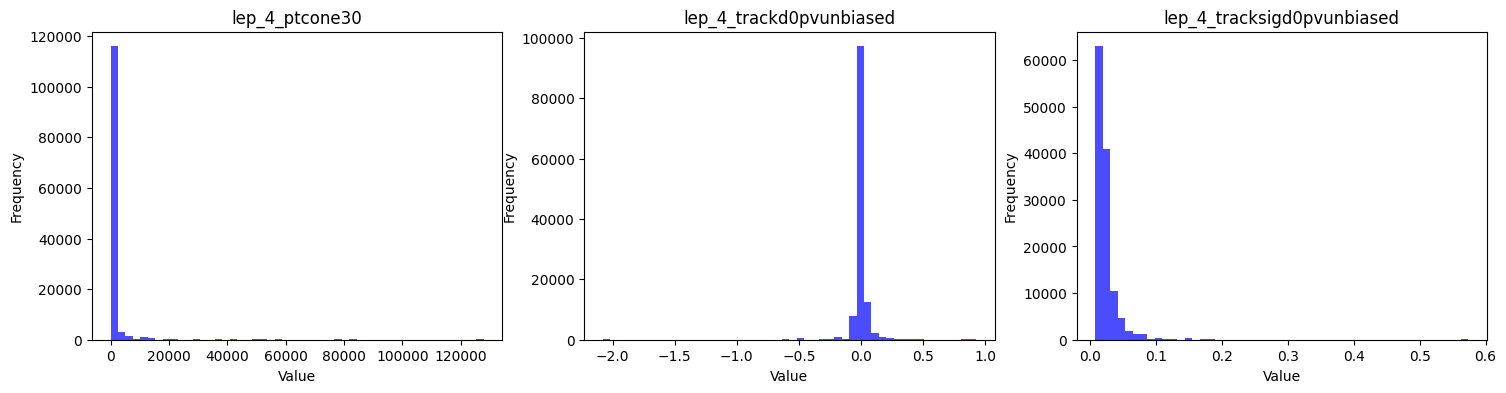

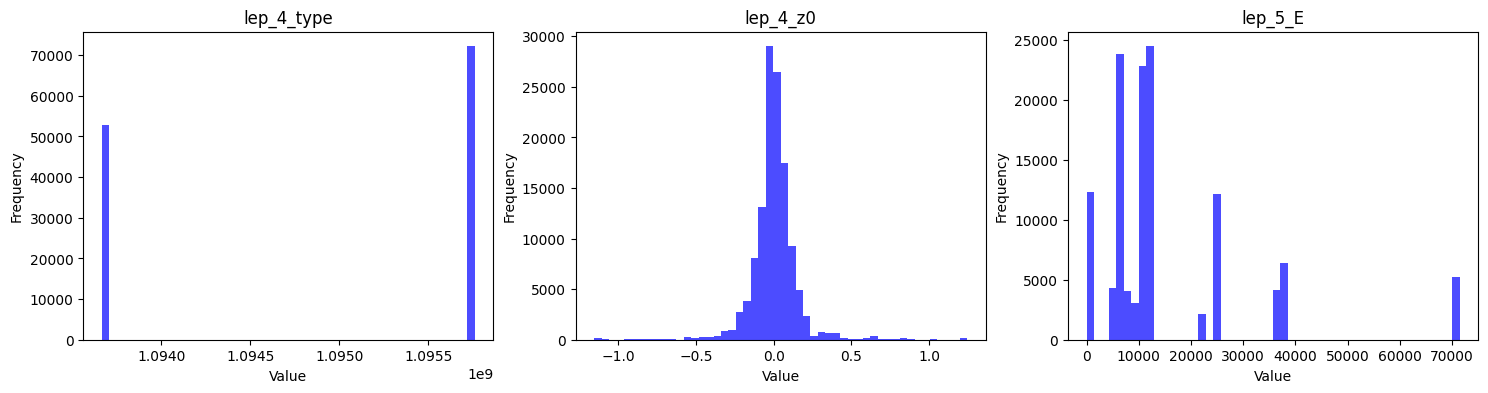

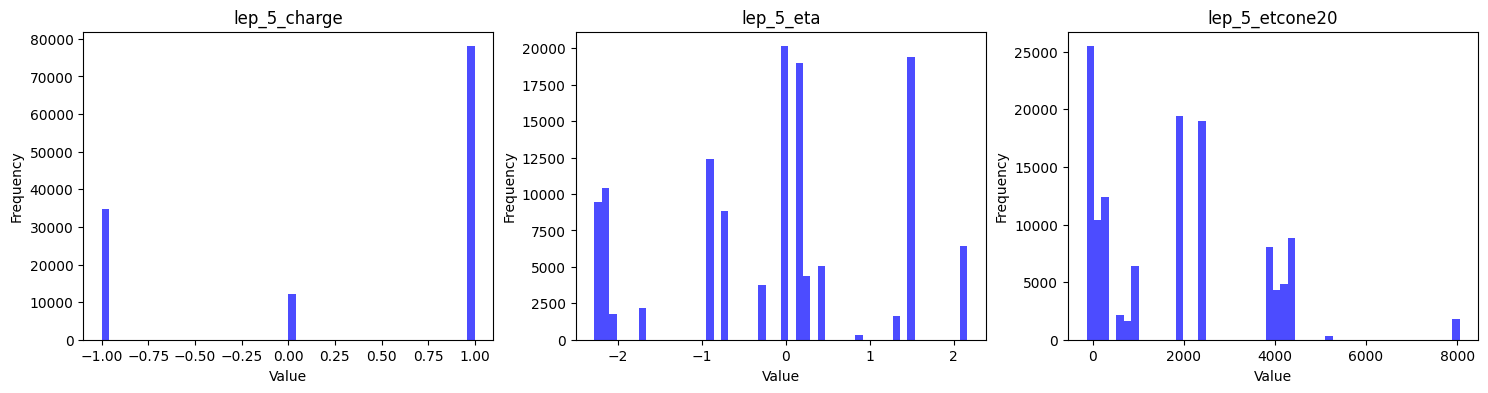

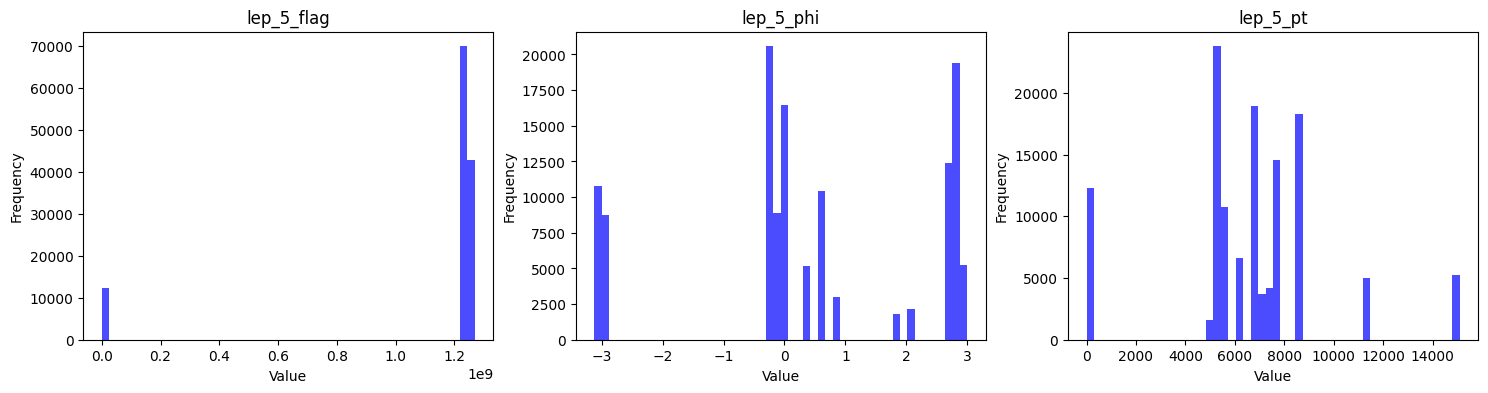

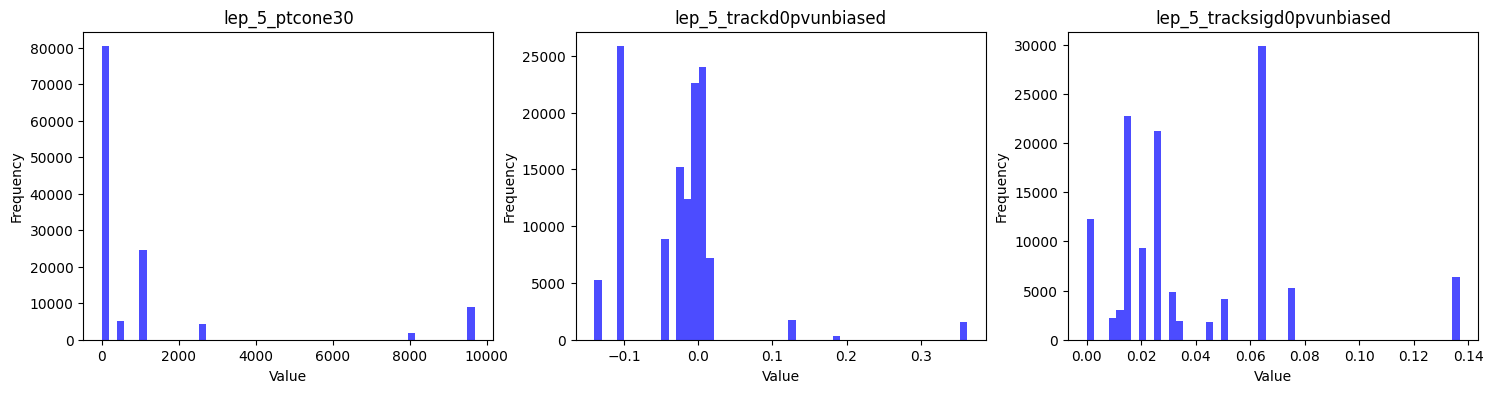

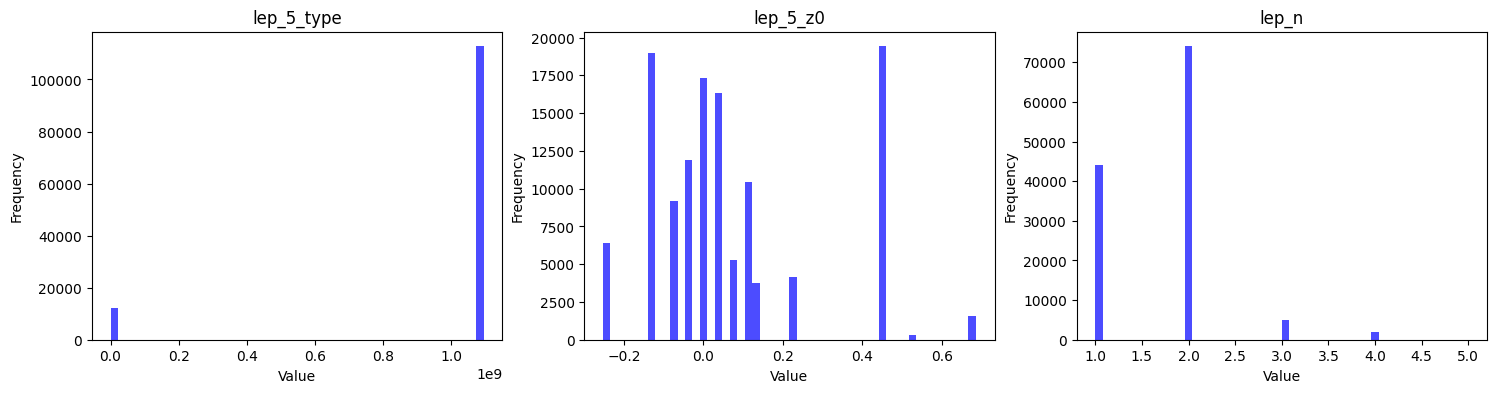

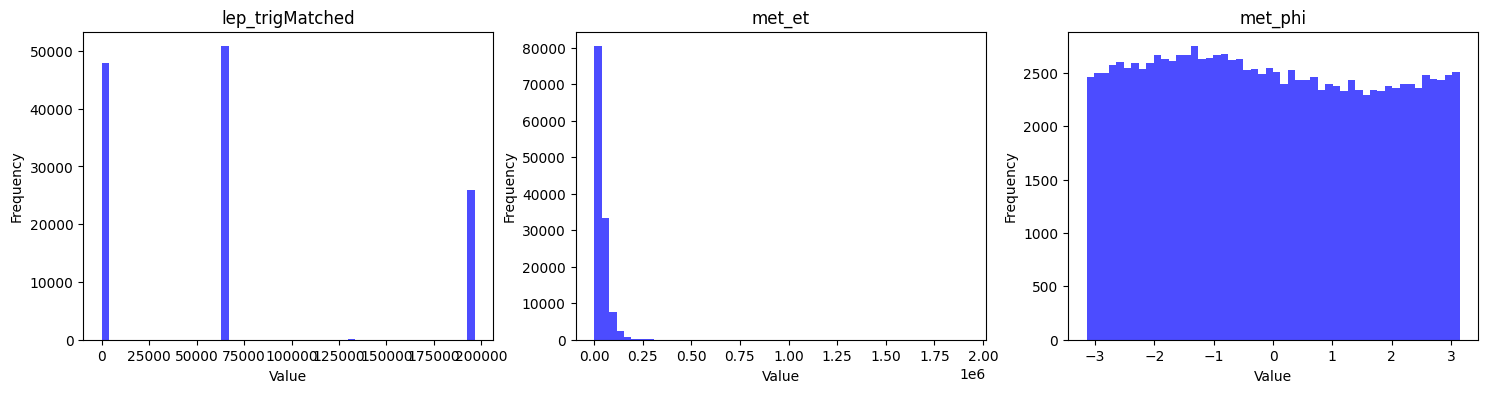

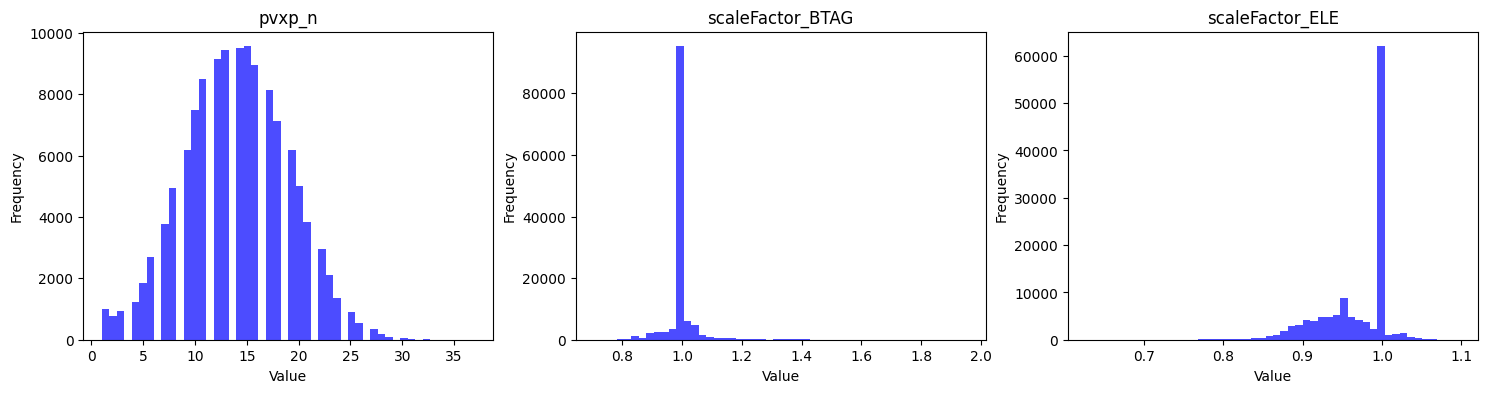

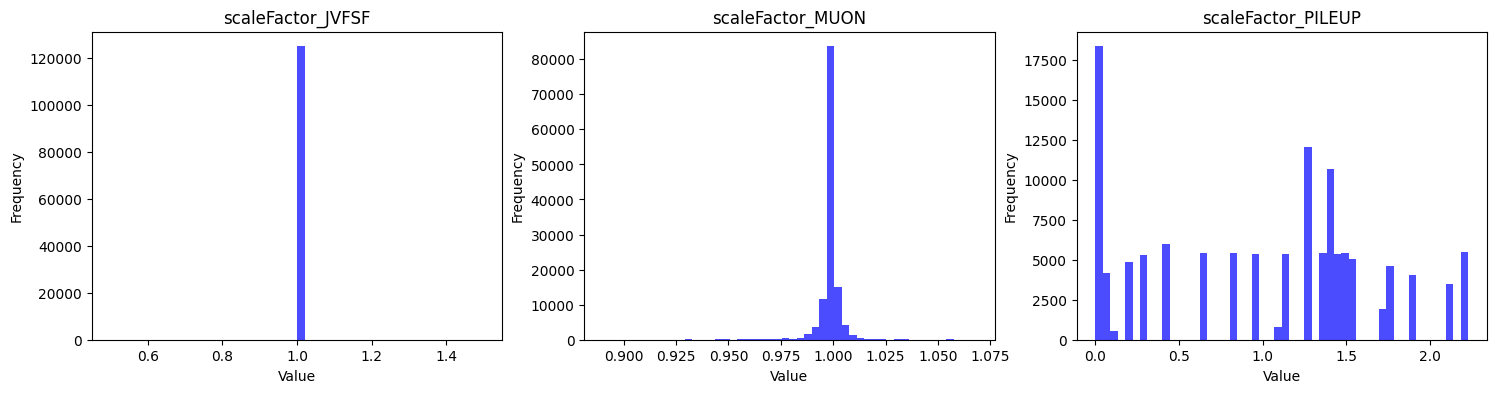

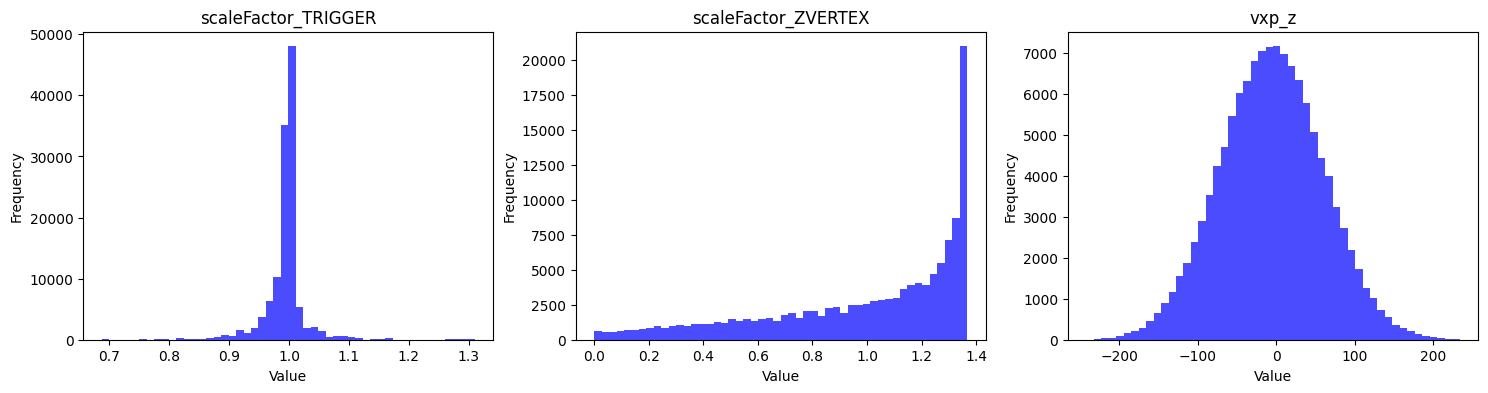

In [10]:
# Extract all features excluding the ones specified -> note: these are manully chosen initially because they are irrelevant for training our model.
# However, we still have to do a more refined feature validation as you will see further down
plot_features = [col for col in data.columns if col not in [
    'eventWeight', 'mcWeight', 'channelNumber', 'runNumber', 'data_type', 'label', 'eventNumber']]

# Create separate figures for each group of features
for i in range(0, len(plot_features), 3):
    # Determine the number of subplots needed
    n_subplots = min(3, len(plot_features) - i)
    fig, axs = plt.subplots(1, n_subplots, figsize=(18, 4))
    # If there's only one subplot, axs will not be an array, so we wrap it in one
    if n_subplots == 1:
        axs = [axs]
    for j in range(n_subplots):
        feature_name = plot_features[i+j]
        axs[j].hist(data[feature_name], bins=50, color='blue', alpha=0.7)
        axs[j].set_xlabel('Value')
        axs[j].set_ylabel('Frequency')
        axs[j].set_title(feature_name)
    plt.show()


### Feature Correlation

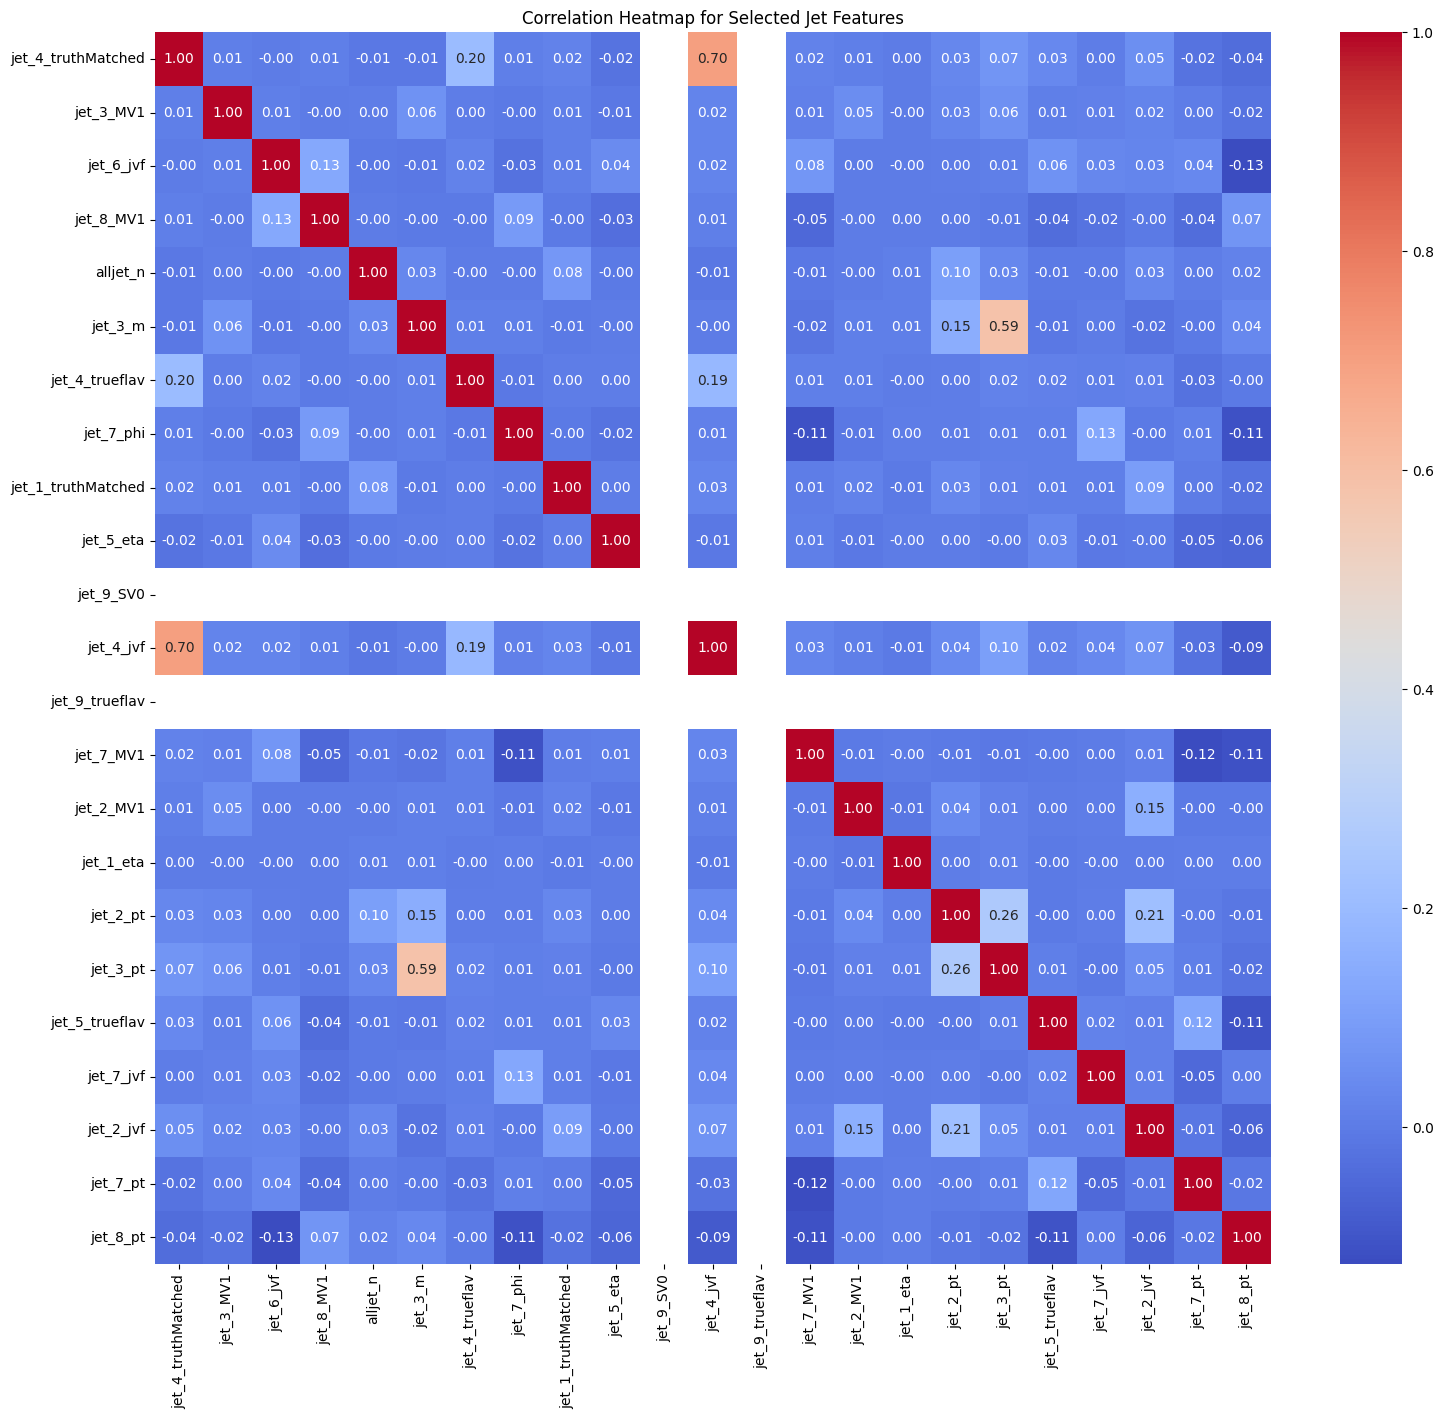

In [11]:
# For jet features, select a random percentage
jet_features = [col for col in data.columns if 'jet' in col]

np.random.seed(42)  # For reproducibility
half_jet_features = np.random.choice(jet_features, size=len(jet_features) // 4, replace=False) # Select the percentage here //
jet_data_half = data[half_jet_features]
jet_correlation_half = jet_data_half.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(jet_correlation_half, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Selected Jet Features')
plt.show()

Here we can see that jet_9_SV0 and Jet_9_trueflav are blank. That indicates that they may have a constant value across all observations. This is confirmed when we watch the histograms above. These can be deleted from the features before training the model.

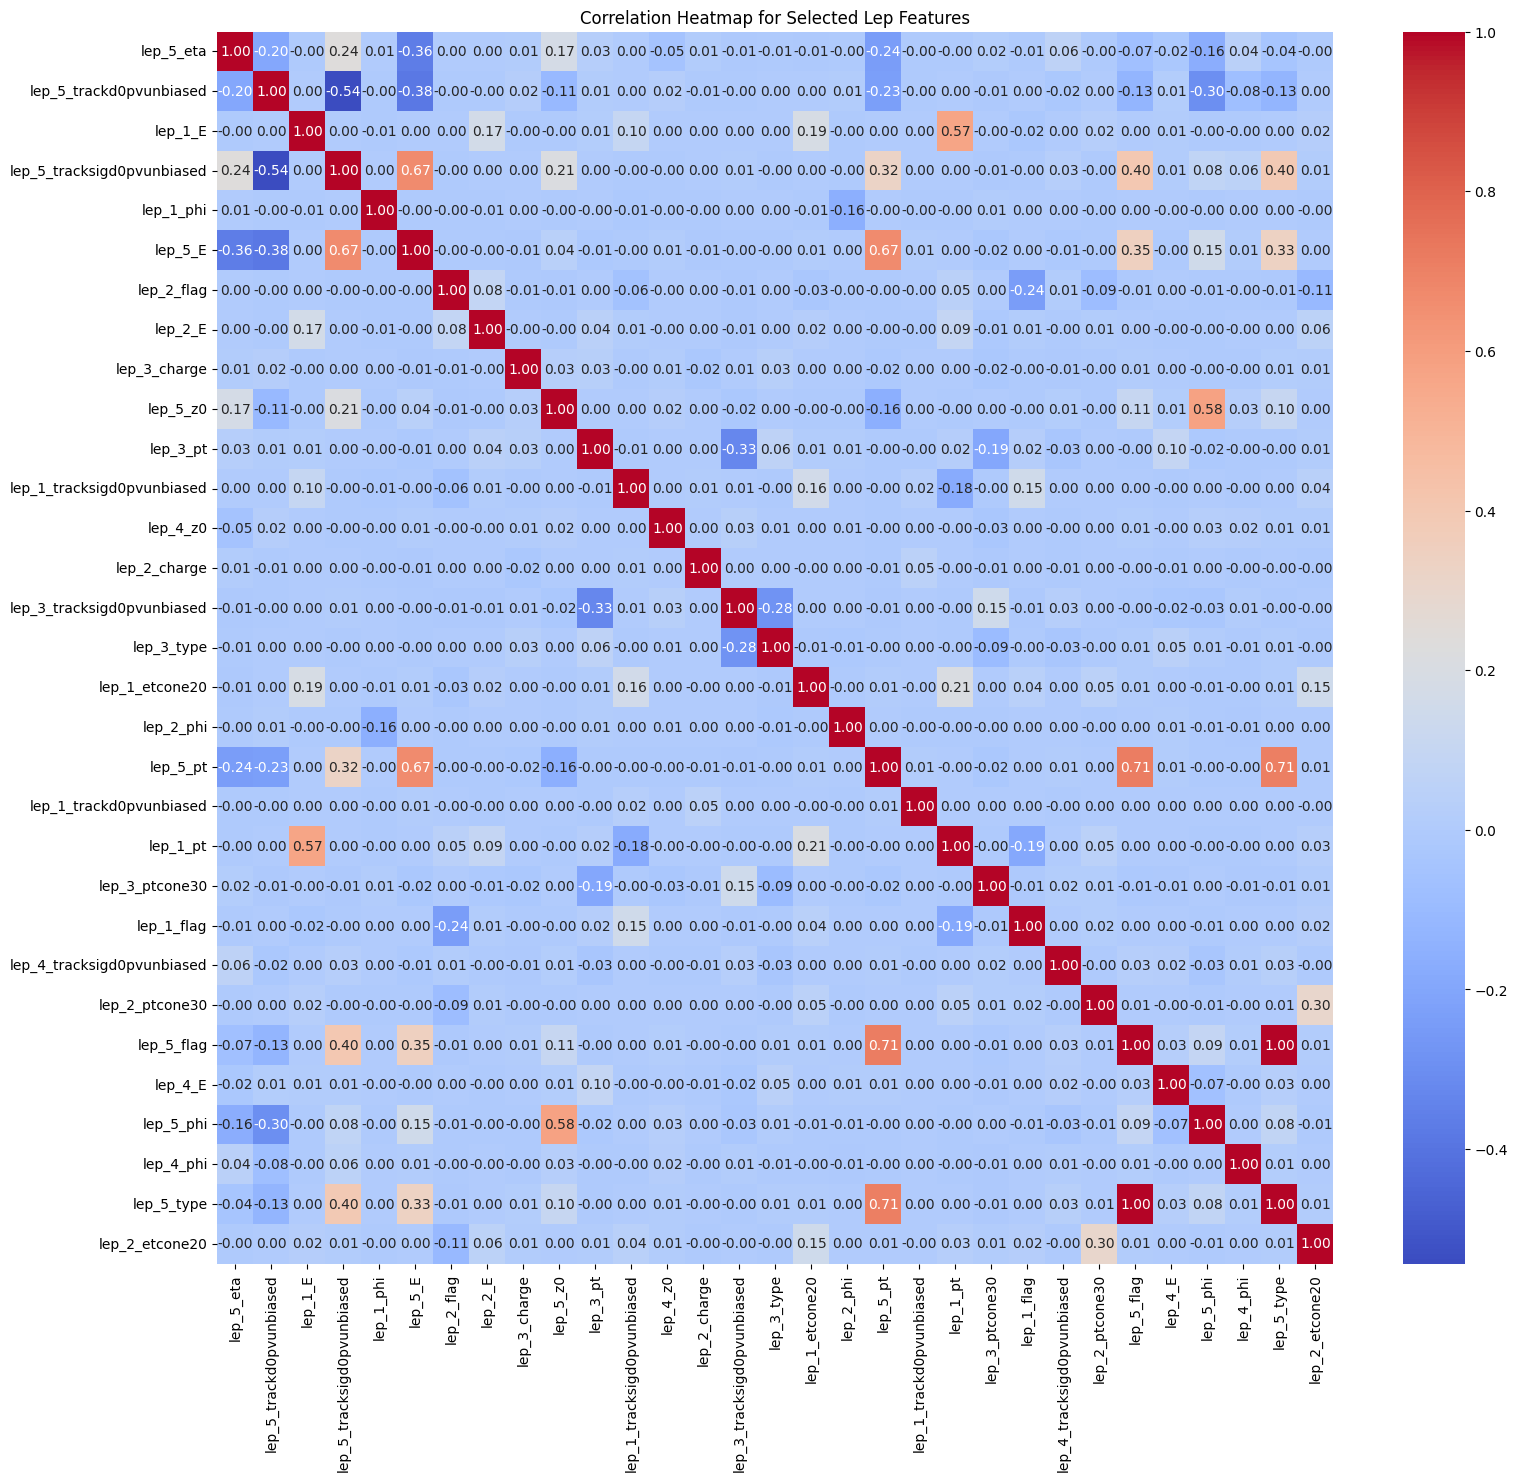

In [12]:
# For lep features, select a random percentage (due to fitting issues)
lep_features = [col for col in data.columns if 'lep' in col]

np.random.seed(42)  # For reproducibility
half_lep_features = np.random.choice(lep_features, size=len(lep_features) // 2, replace=False) # Select the percentage here //
lep_data_half = data[half_lep_features]
lep_correlation_half = lep_data_half.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(lep_correlation_half, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Selected Lep Features')
plt.show()

These heatmaps illustrates the correlation between various features in the dataset. The main diagonal, showing perfect correlation, represents each feature's correlation with itself. Off-diagonal bright spots indicate a high positive correlation between different features.

#### We inspected the histograms again and we found 6 features that offers no variability

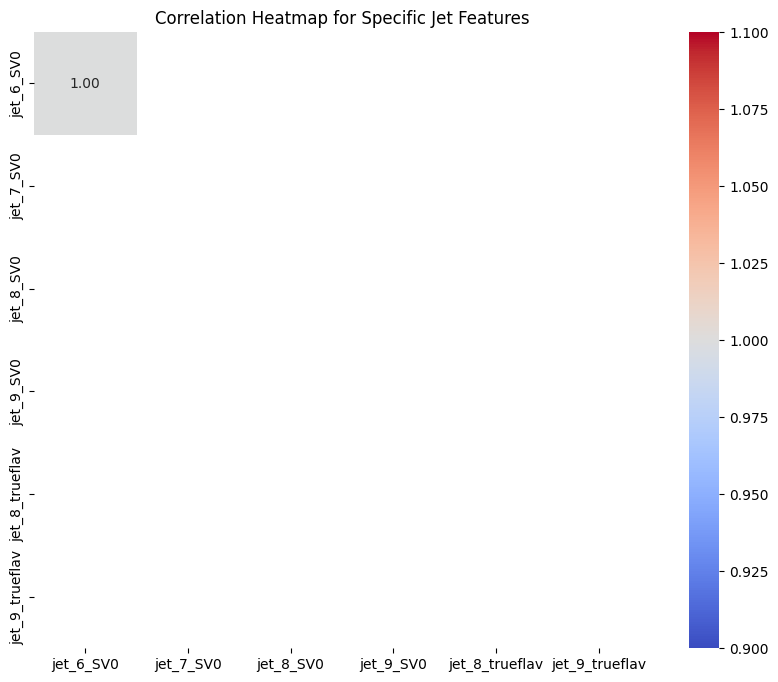

In [13]:
# List of specific features to plot
specific_features = ['jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0', 'jet_8_trueflav', 'jet_9_trueflav']

# Selecting the data for these specific features
specific_data = data[specific_features]

# Computing the correlation matrix
specific_correlation = specific_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(specific_correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap for Specific Jet Features')
plt.show()


### Inspecting Background vs Signal events
To distinguish between background and signal datasets, we plot feature distributions for a selection of the datasets. These visualizations reveal differences in feature behaviors, supporting our dataset classification into 'background' (Standard Model processes) and 'signal' (hypothetical Z' particle events).

Keys in this dataset: ['mini']
Background sample shape: (125000, 169)
Keys in this dataset: ['mini']
Signal sample shape: (23224, 169)


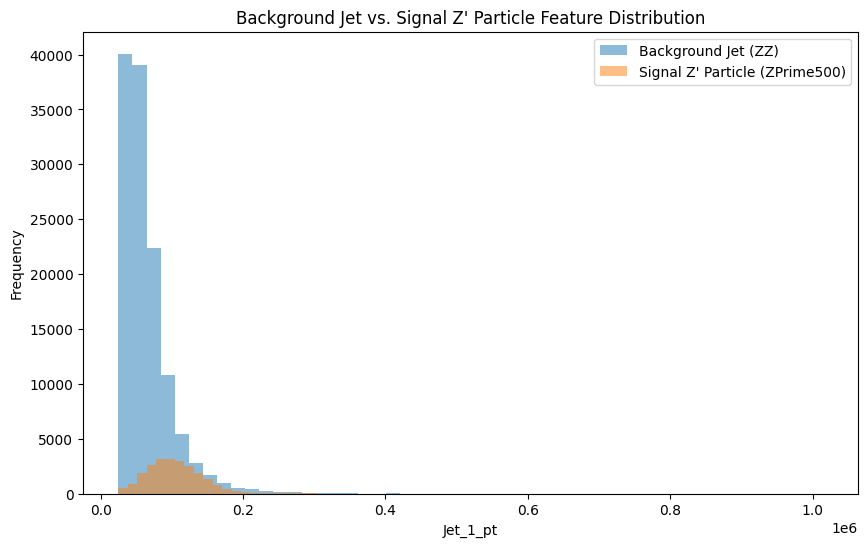

In [14]:
# Function to load and inspect dataset structure
def load_and_inspect(file_path):
    with h5py.File(file_path, 'r') as file:
        print("Keys in this dataset:", list(file.keys()))
        data = np.array(file['mini'])
        return pd.DataFrame(data)

# Load a background dataset (These are identified by their names)
background_sample = load_and_inspect(path + 'mc_105986.ZZ.hdf5')
print("Background sample shape:", background_sample.shape)

# Load a signal dataset (These are identified by their names)
signal_sample = load_and_inspect(path + 'mc_110901.ZPrime500.hdf5')
print("Signal sample shape:", signal_sample.shape)

# Plotting the feature distribution for a jet from background
plt.figure(figsize=(10, 6))
plt.hist(background_sample['jet_1_pt'], bins=50, alpha=0.5, label='Background Jet (ZZ)')
plt.title('Background Jet vs. Signal Z\' Particle Feature Distribution')
plt.xlabel('Jet_1_pt')
plt.ylabel('Frequency')

# Plotting the feature distribution for a Z' particle from signal
plt.hist(signal_sample['jet_1_pt'], bins=50, alpha=0.5, label='Signal Z\' Particle (ZPrime500)')
plt.legend(loc='best')
plt.show()


As we can see, the dataset has significantly more background events than signal events, it's important to acknowledge this class imbalance as it can have an impact on model training and evaluation.

### Feature Selection using Random forest
We will use a random forest model to train a subset of the data.
Then we will measure and rank the Feature Importance.
Those results will give us an indication of which features we should keep to have a good performing model,
but we need to manually check features as well before retraining the model on our newly chosen features.

In [15]:
# Explicitly delete 'data' to free up memory
import gc
del data
gc.collect()  # Trigger garbage collection to free up memory

15486

### Define Data Subset Loading Function 

In [16]:
def load_subset_data(file_list, label, subset_percentage):
    df_combined = pd.DataFrame()
    for file in file_list:
        with h5py.File(path + file, 'r') as f:
            data = f['mini'][:]
        
        # Determine the subset size based on the percentage
        subset_size = int(len(data) * subset_percentage)
        
        # Take a random subset of data
        np.random.shuffle(data)
        data = data[:subset_size]
        
        data_df = pd.DataFrame(data)
        data_df['label'] = label
        df_combined = pd.concat([df_combined, data_df])
    return df_combined

### Load Data Subset

In [17]:
# Load a subset of background and signal data - set the percentage here
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

### Combine and Shuffle Data

In [18]:
# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=42)

# Free up RAM by deleting the dataframes
del df_background
del df_signal
gc.collect()  # Trigger garbage collection to free up memory

0

### Define features and Labels

In [19]:
# Define features to exclude from the model - note: these are manully chosen initially after doing data analyzing of histograms and correlation matrixes.
# However, we still have to do a more refined feature validation as you will see further down
excluded_features = ['eventWeight', 'mcWeight', 'channelNumber', 'runNumber', 'data_type', 'label', 'eventNumber', 'jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0', 'jet_8_trueflav', 'jet_9_trueflav'
] # We can manually add more features here to exclude


# Select features for training the model
features = [col for col in df_combined.columns if col not in excluded_features]


### Prepare Data for Training

In [20]:
# Prepare the feature matrix (X) and the target vector (y)
X = df_combined[features]
y = df_combined['label']

# Split the data into training and test sets using a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Train the first Random Forest Classifier

In [21]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)

Time: 0 hours, 55 minutes, 45 seconds


### Rank the feature importance

In [22]:
pd.set_option('display.max_rows', None) # Option to show all features
# Get feature importance scores
feature_importance = rf_clf.feature_importances_

# Create a Series with feature importance scores, indexed by feature names
feature_importance_series = pd.Series(feature_importance, index=X_train.columns)

# Sort the features by their importance scores in descending order
sorted_features = feature_importance_series.sort_values(ascending=False)

# Print the sorted features with their importance scores
print("Features ranked by importance:")
print(sorted_features)

Features ranked by importance:
lep_5_phi                     0.070302
lep_5_flag                    0.050947
jet_1_pt                      0.049805
met_et                        0.044680
lep_5_tracksigd0pvunbiased    0.044501
lep_5_trackd0pvunbiased       0.041013
jet_1_m                       0.040040
lep_5_etcone20                0.035856
lep_5_pt                      0.035844
lep_5_ptcone30                0.035831
lep_5_z0                      0.032847
lep_5_E                       0.030244
lep_4_pt                      0.029661
lep_1_pt                      0.025468
lep_4_flag                    0.023804
lep_5_eta                     0.022868
lep_4_phi                     0.021630
jet_1_E                       0.021215
jet_2_pt                      0.019973
lep_4_ptcone30                0.019970
lep_4_tracksigd0pvunbiased    0.019229
lep_4_trackd0pvunbiased       0.013318
lep_4_E                       0.011847
lep_4_etcone20                0.011374
lep_4_z0                      0.0

### Evaluate the model on all the features above

Test Accuracy: 0.9998097837506663


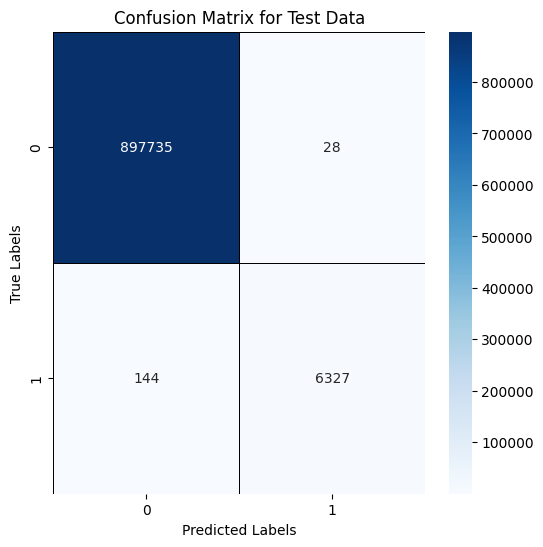

In [23]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


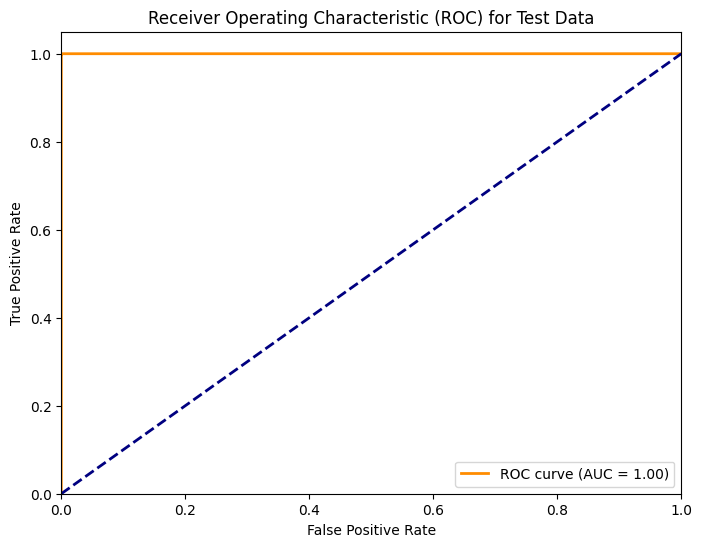

In [24]:
# Calculate the ROC curve for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test)

# Calculate the AUC (Area Under the Curve) for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Test Data')
plt.legend(loc='lower right')
plt.show()

### Select the new features
After inspecting the features manually, both in histograms and correlation in the dataexploration part where we plotted those, we chose do go forward with top 35 features.

In [25]:
top_features_indices = feature_importance.argsort()[-35:][::-1] # Change the number of top features here
selected_features = X_train.columns[top_features_indices]

### Train the Random Forest Classifier again with the new selected features

In [26]:
X_train_selected = X_train[selected_features]
rf_clf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_clf_selected.fit(X_train_selected, y_train)
end_time = time.time()

training_time = end_time - start_time
hours, minutes, seconds = int(training_time // 3600), int((training_time % 3600) // 60), int(training_time % 60)
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)

Time: 0 hours, 21 minutes, 0 seconds


### Evaluate the newly trained model on the updated features

Accuracy with the new selected features: 0.9999480223039612


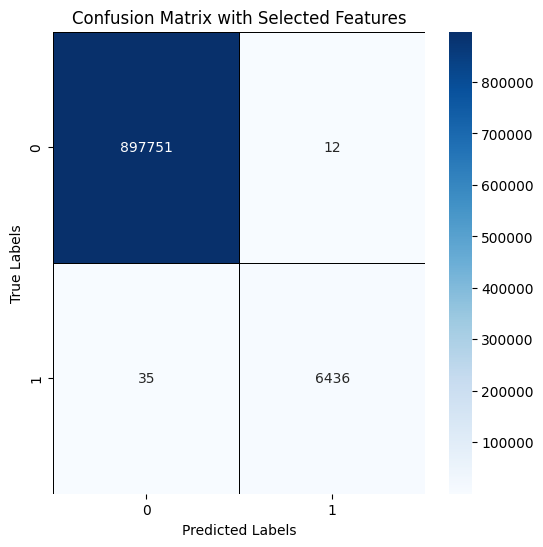

In [27]:
# Predict on the test set using the newly trained model with selected features
y_pred_selected = rf_clf_selected.predict(X_test[selected_features])
y_probs_selected = rf_clf_selected.predict_proba(X_test[selected_features])[:, 1]

# Calculate accuracy for the newly trained model
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy with the new selected features: {accuracy_selected}")

# Generate a confusion matrix for the newly trained model
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)

# Plot the confusion matrix with custom formatting for the newly trained model
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Selected Features')
plt.show()


This model has a remarkable high accuracy. It is important to acknowlegde that this might be because of the imbalanced dataset, but also, the fact that our dataset is so well prepared makes the job very easy on simulated data.
That being said, the fact that the predictions drastically improved after doing our feature selection, might imply that we actually are on the right path, especially knowing these simulated datasets are well prepared.

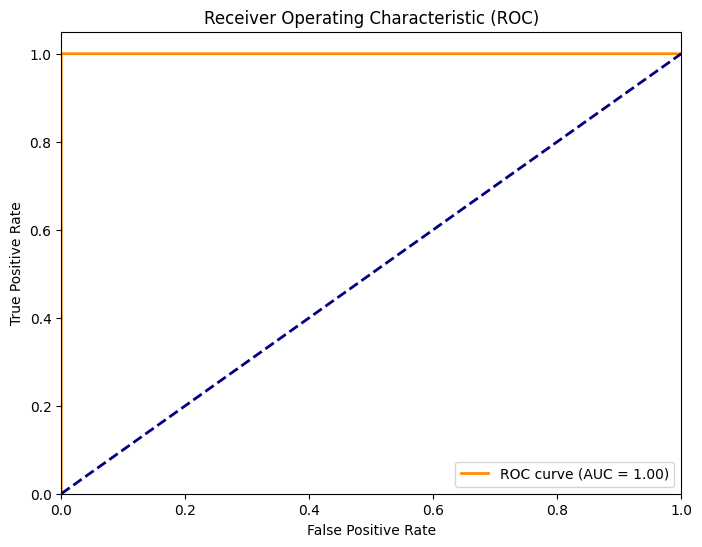

In [28]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_selected)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Balancing the datasets
Now, we will try to balance the datasets as we know that there are many more background files than signal files.

### Undersampling

In [ ]:
# Delete variables to free up memory
del y_pred_selected, y_probs_selected, conf_matrix_selected, rf_clf_selected

# Call garbage collection
gc.collect()

In this step, we're balancing our dataset by ensuring that the number of signal and background events are equal. We first load all signal data into a single DataFrame. Given the total number of signal events, we then calculate how many background events per file we need to match this number. After loading the necessary background events, we combine both signal and background data into a balanced DataFrame. This approach helps us manage memory efficiently by cleaning up intermediate variables and using garbage collection.

In [44]:
# Load all signal data and add label
df_signal_list = []
for file in signal_files:
    with h5py.File(path + file, 'r') as f:
        data = pd.DataFrame(f['mini'][:])
        data['label'] = 1  # Signal label
        df_signal_list.append(data)

# Concatenate all signal data into a single DataFrame
df_signal = pd.concat(df_signal_list, ignore_index=True)

# Determine the number of background entries to match the signal data size
total_signal_entries = len(df_signal)
background_entries_per_file = total_signal_entries // len(background_files)

# Load a balanced subset of background data and add label
df_background_list = []
for file in background_files:
    with h5py.File(path + file, 'r') as f:
        data = pd.DataFrame(f['mini'][:]).sample(n=background_entries_per_file)
        data['label'] = 0  # Background label
        df_background_list.append(data)

# Concatenate all background data into a single DataFrame
df_background = pd.concat(df_background_list, ignore_index=True)

# Combine signal and background data
df_balanced = pd.concat([df_signal, df_background], ignore_index=True)

# Shuffle the combined DataFrame
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)


In [45]:
# Count the number of signal and background entries
signal_count = df_balanced[df_balanced['label'] == 1].shape[0]
background_count = df_balanced[df_balanced['label'] == 0].shape[0]

print(f"Number of signal entries: {signal_count}")
print(f"Number of background entries: {background_count}")

Number of signal entries: 163308
Number of background entries: 163300


In [46]:
# Define features to exclude from the model -> We repeat this to better compare to the basemodel (first trained random forest model)
excluded_features = ['eventWeight', 'mcWeight', 'channelNumber', 'runNumber', 'data_type', 'label', 'eventNumber', 'jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0', 'jet_8_trueflav', 'jet_9_trueflav']

# Select features for training the model
features = [col for col in df_balanced.columns if col not in excluded_features]

# Prepare the feature matrix (X) and the target vector (y)
X = df_balanced[features]
y = df_balanced['label']

# Clean up the balanced dataframe to free up memory
del df_balanced
gc.collect()

9422

### Prepare for training

In [47]:
# Split the data into training and test sets using a 60-40 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

### Train the balanced dataset

In [48]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)

Time: 0 hours, 3 minutes, 25 seconds


### Evaluate the model

Test Accuracy: 0.9997780227182266


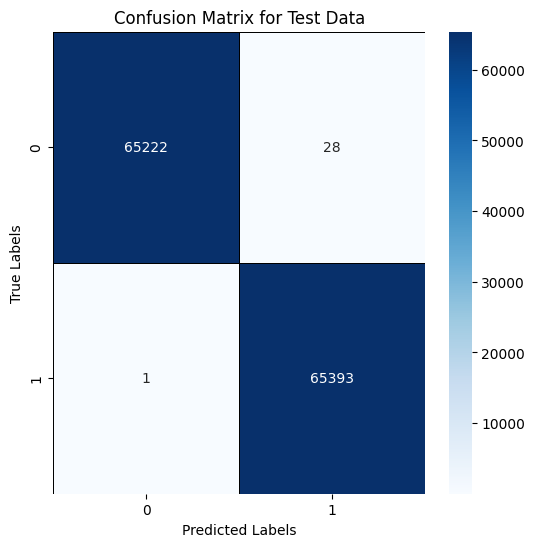

In [49]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


The updated confusion matrix after balancing the dataset shows a significant improvement in the model's sensitivity, evidenced by a drop in false negatives from 144 to just 1. This implies the model's enhanced capability to detect true signals. Meanwhile, the number of false positives remains constant at 28, indicating that the model's specificity—its ability to recognize negatives—has not been affected by the balancing. It's crucial to consider that these observations are based on a smaller dataset, which may influence the comparison with the baseline model.

### Oversampling

In [54]:
# First we load a subset of background and signal data -> Just like the baseline model
subset_percentage = 0.1
df_background = load_subset_data(background_files, 0, subset_percentage)
df_signal = load_subset_data(signal_files, 1, subset_percentage)

# Combine background and signal data
df_combined = pd.concat([df_background, df_signal])

# Shuffle the combined DataFrame
df_combined = shuffle(df_combined, random_state=42)


To address the imbalance in our dataset, we apply oversampling to the the Minority Class (signal data). This involves duplicating signal entries to match the number of background entries, creating a balanced dataset for our model to train on.


In [57]:
from sklearn.utils import resample

# Oversample signal data to match the number of background samples
df_signal_oversampled = resample(df_signal,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_background),    # to match majority class
                                 random_state=42)  # for reproducibility

# Combine the oversampled signal data with the background data
df_oversampled = pd.concat([df_background, df_signal_oversampled])

# Shuffle the combined DataFrame to ensure a good mix
df_oversampled = shuffle(df_oversampled, random_state=42).reset_index(drop=True)

# Delete the original signal dataframes to free up memory
del df_signal_oversampled, df_background, df_signal
gc.collect()  # Trigger garbage collection to free up memory

# Call garbage collection
gc.collect()

0

### Prepare Data for Training

In [58]:
# Define features to exclude from the model
excluded_features = ['eventWeight', 'mcWeight', 'channelNumber', 'runNumber', 'data_type', 'label', 'eventNumber', 'jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0', 'jet_8_trueflav', 'jet_9_trueflav']

# Select features for training the model
features = [col for col in df_oversampled.columns if col not in excluded_features]

# Prepare the feature matrix (X) and the target vector (y)
X = df_oversampled[features]
y = df_oversampled['label']

# Split the data into training and test sets using a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


### Train the Random Forest Classifier - Oversampled

In [59]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Start the timer
start_time = time.time()

# Train the model on the training data
rf_clf.fit(X_train, y_train)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Calculate hours, minutes, and seconds
hours = int(training_time // 3600)
minutes = int((training_time % 3600) // 60)
seconds = int(training_time % 60)

# Format the training time
formatted_training_time = f"Time: {hours} hours, {minutes} minutes, {seconds} seconds"
print(formatted_training_time)


Time: 1 hours, 20 minutes, 4 seconds


### Evaluate the Model

Test Accuracy: 0.999996101156063


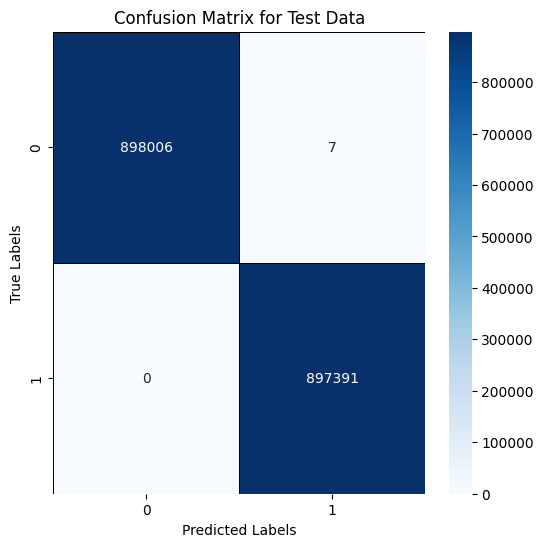

In [60]:
# Predict on the test set
y_pred_test = rf_clf.predict(X_test)
y_probs_test = rf_clf.predict_proba(X_test)[:, 1]  # Probability estimates for ROC curve on test data

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# Generate a confusion matrix for the test set predictions
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix with custom formatting for the test data
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Data')
plt.show()


#### This is by far the highest accuracy we have managed until now.